# Adults Census Model Training
## Scikit-learn: Decision Tree Algorithm

## Outline

1. [Setup Development Environment](#setup)
    - 1.1 [Amazon SageMaker](#aws_setup)
    - 1.2 [Azure Machine Learning Service](#amls_setup)
    - 1.3 [IBM Watson Machine Learning](#wml_setup)
2. [Data Preparation](#data_prep)
    - 2.1 [Download and Preprocessing](#data)
    - 2.2 [Uploading data to Amazon S3 bucket](#aws_data)
    - 2.3 [Uploading data to AMLS data store](#amls_data)
3. [Model Training](#train)
    - 3.1 [Run locally (My Desktop hardware)](#3_1)
        - 3.1.1 [hardware info](#3_1_1)
        - 3.1.2 [Model Training](#3_1_2)        
    - 3.2 [Submit the Training Job to the SageMaker Compute Cluster](#3_2)
        - 3.2.1 [hardware info](#3_2_1)
        - 3.2.2 [Model Training](#3_2_2)    
    - 3.3 [Submit the Training Job to the AMSL Compute Cluster](#3_3)  
        - 3.2.1 [hardware info](#3_3_1)
        - 3.2.2 [Model Training](#3_3_2) 
     - 3.4 [Train Model on IBM runtime environment hardware](#3_4)
        - 3.4.1 [hardware info](#3_4_1)
        - 3.4.2 [Model Training](#3_4_2)
4. [Model Comparison](#compaire)

<a id="setup"></a>
### 1 Set up Development Environment
   - 1.1 [Amazon SageMaker](#aws_setup)
   - 1.2 [Azure Machine Learning Service](#amls_setup)
   - 1.3 [IBM Watson Machine Learning](#wml_setup)

<a id="aws_setup"></a> 
- 1.1 Amazon SageMaker
    Steps:
    - Import base Amazon SageMaker ML packages
    - Check the SDK version
    - Create S3 bucket

In [1]:
# base packages to work with SageMaker
import boto3
from sagemaker import get_execution_role
import sagemaker

# check core SDK version number
print("Ready to use Amazon SageMaker", sagemaker.__version__)

Ready to use Amazon SageMaker 2.16.4.dev0


In [2]:
# S3 prefix
prefix = 'Scikit-adults'

# Now let's define the S3 bucket
sm_boto3 = boto3.client('sagemaker')
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = sess.default_bucket()  # this could also be a hard-coded bucket name
print(f'Using S3 bucket: {bucket}')

Using S3 bucket: sagemaker-us-east-2-359732627051


<a id="amls_setup"></a> 
- 1.2 Azure Machine Learning Service
    Steps: 
    - create workspace
    - create compute        

In [1]:
# base packages to work with AMLS
import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Ready to use Azure ML", azureml.core.VERSION)

Ready to use Azure ML 1.19.0


In [7]:
# create a workspace

SUBSCRIPTION_ID='79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5' # provide your subscription ID
RESOURCE_GROUP_NAME  = 'unive-resource-group' # provide a resource group name
WORKSPACE_NAME  = 'unive-workspace' # provide a name for your workspace
REGION = 'westeurope' # For example: 'westeurope' or 'eastus2' or 'westus2' or 'southeastasia'.

ws = None
try:
    # Find existing workspace
    ws = Workspace(workspace_name=WORKSPACE_NAME,
                   subscription_id=SUBSCRIPTION_ID,
                   resource_group= RESOURCE_GROUP_NAME)
    print (ws.name, "found.")
except Exception as ex:
    # If workspace not found, create it
    print(ex.message)
    print("Attempting to create new workspace...")
    ws = Workspace.create(name=WORKSPACE_NAME, 
                          subscription_id=SUBSCRIPTION_ID,
                          resource_group=RESOURCE_GROUP_NAME,
                          create_resource_group=True,
                          location=REGION)
    print(ws.name, "created.")
finally:
    # Save the workspace configuration for later
    if ws != None:
        # write out the workspace details to a configuration file: .azureml/config.json
        ws.write_config(path='.azureml')
        print(ws.name, "saved.")

get_workspace error using subscription_id=79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5, resource_group_name=unive-resource-group, workspace_name=unive-workspace


Workspace not found.
Attempting to create new workspace...
Deploying KeyVault with name univeworkeyvault266670b4.
Deploying StorageAccount with name univeworstorage40e96b128.
Deployed KeyVault with name univeworkeyvault266670b4. Took 19.43 seconds.
Deploying AppInsights with name univeworinsights39cc39a9.
Deployed AppInsights with name univeworinsights39cc39a9. Took 26.85 seconds.
Deploying Workspace with name unive-workspace.
Deployed StorageAccount with name univeworstorage40e96b128. Took 47.79 seconds.
Deployed Workspace with name unive-workspace. Took 20.08 seconds.
unive-workspace created.
unive-workspace saved.


In [2]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep='\t')

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code C9MVV7LX5 to authenticate.
You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.
unive-workspace	westeurope	unive-resource-group	westeurope


In [9]:
# create compute

from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

ws = Workspace.from_config() # This automatically looks for a directory .azureml
CPU_CLUSTER_NAME = "cpu-cluster" # Choose a name for your CPU cluster

# Verify that the cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=CPU_CLUSTER_NAME)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_D1_v2',
                                                            min_nodes = 1,
                                                            max_nodes=2, #will autoscale between zero and two nodes
                                                            idle_seconds_before_scaledown=300)
    cpu_cluster = ComputeTarget.create(ws, CPU_CLUSTER_NAME, compute_config)

cpu_cluster.wait_for_completion(show_output=True)

# Virtual machine size: STANDARD_D1_V2 (1 Cores, 3.5 GB RAM, 50 GB Disk)
# Processing Unit: CPU - General purpose
# Virtual machine priority: Dedicated
# Minimum number of nodes: 1
# Maximum number of nodes: 2

Creating
Succeeded.......................
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


<a id="wml_setup"></a> 
- 1.3 IBM Watson Studio

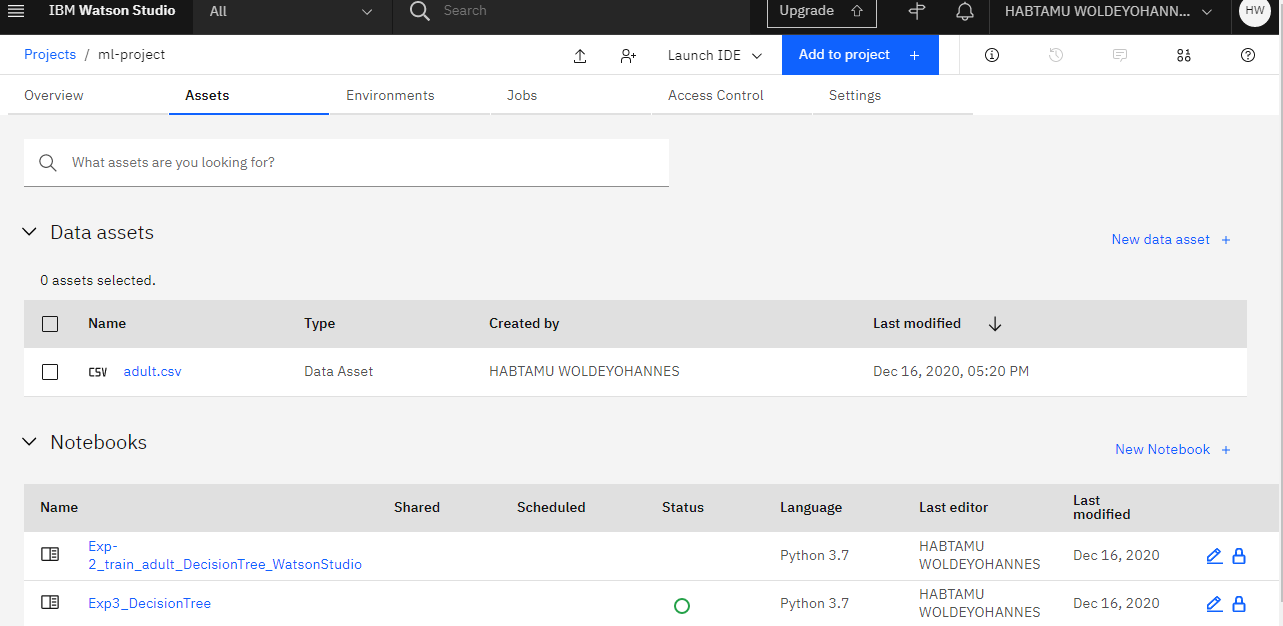

In [1]:
from IPython.display import Image
Image(filename='images/Watson/setup.png')

<a id="data_prep"></a>
### 2. Data Preparation
- 2.1 [Download and Preprocessing](#data)
- 2.2 [Uploading data to Amazon S3 bucket](#aws_data)
- 2.3 [Uploading data to AMLS data store](#amls_data)

<a id="data"></a> 
2.1 Download and Preprocessing

- We download Adult Census Income Binary classfication dataset and prepreocessing
- Dataset: https://archive.ics.uci.edu/ml/datasets/Adult

In [3]:
import os
import datetime
import time
import tarfile
import pandas as pd
import numpy as np

## read the data
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header = None, na_values=' ?')

## read test data
data_test = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test", header = None, skiprows=1, na_values=' ?')

## set column names
data.columns = ['age', 'workclass','fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 
'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'IncomeGroup']

data_test.columns = ['age', 'workclass','fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 
'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'IncomeGroup']

print(np.unique(data.loc[:,'IncomeGroup'].values.tolist()))
print(np.unique(data_test.loc[:,'IncomeGroup'].values.tolist()))

[' <=50K' ' >50K']
[' <=50K.' ' >50K.']


In [4]:
# preprocess

d = {' <=50K': 0,
     ' >50K': 1}
data['IncomeGroup'] = data['IncomeGroup'].map(d)

t = {' <=50K.': 0,
     ' >50K.': 1}
data_test['IncomeGroup'] = data_test['IncomeGroup'].map(t)

# Combine the two datasets to convert the categorical values to binary indicators
data_combined = pd.concat([data, data_test])
c = {0 : ' <=50K',
     1 : ' >50K'}
data_combined['IncomeGroup'] = data_combined['IncomeGroup'].map(c)
print(f"data_combined.shape: {data_combined.shape}")

# drop rows with missing
data_combined = data_combined.dropna()
print(f"data_combined.shape (After dropna): {data_combined.shape}")

# display data
data_combined.head()

data_combined.shape: (48842, 15)
data_combined.shape (After dropna): (45222, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,IncomeGroup
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
np.unique(data_combined.loc[:,'IncomeGroup'].values.tolist())

array([' <=50K', ' >50K'], dtype='<U6')

In [6]:
# summarize the class distribution
import collections

target = data_combined.values[:,-1]
counter = collections.Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class= <=50K, Count=34014, Percentage=75.216%
Class= >50K, Count=11208, Percentage=24.784%


In [8]:
cat_ix = data_combined.select_dtypes(include=['object', 'bool']).columns
num_ix = data_combined.select_dtypes(include=['int64', 'float64']).columns

print(f"cat_ix:{cat_ix}")
print(f"num_ix:{num_ix}")

cat_ix:Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'IncomeGroup'],
      dtype='object')
num_ix:Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


<a id="aws_data"></a> 
- 2.2 Uploading data to Amazon S3 bucket

In [4]:
import os

# Create directory
os.makedirs('./data', exist_ok=True)

In [5]:
#send data to S3 
WORK_DIRECTORY = 'data'
train_input = sess.upload_data(WORK_DIRECTORY, key_prefix="{}/{}".format(prefix, WORK_DIRECTORY))
train_input

's3://sagemaker-us-east-2-359732627051/Scikit-adults/data'

<a id="amls_data"></a> 
- 2.3 Uploading data to AMLS data store

In [10]:
## Upload data to datastore

# Get the default datastore
default_ds = ws.get_default_datastore()

# Enumerate all datastores, indicating which is the default
for ds_name in ws.datastores:
    print(ds_name, "- Default =", ds_name == default_ds.name) # workspaceblobstore <- Default

# Adult Census Income Binary classfication dataset
default_ds.upload_files(files=['./data/adult.csv'], # Upload the data/adults.csv file
                       target_path='adults-data/', # Put it in a folder path in the datastore
                       overwrite=True, # Replace existing files of the same name
                       show_progress=True)

workspacefilestore - Default = False
workspaceblobstore - Default = True
Uploading an estimated of 1 files
Uploading ./data/adult.csv
Uploaded ./data/adult.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_c58799dae0e24a82a18c75238f739fb7

<a id="train"></a>
### 3 Model Training

- 3.1 [Run locally (My Desktop hardware)](#3_1)
- 3.2 [Submit the Training Job to the SageMaker Compute Cluster](#3_2)
- 3.3 [Submit the Training Job to the AMSL Compute Cluster](#3_3)
- 3.4 [Train Model on IBM runtime environment hardware](#3_4)


<a id="3_1"></a>
##### 3.1 Run locally (My Desktop hardware)
Here we can run model Training locally use my desktop hardware:

- 3.1.1 [hardware info](#3_1_1)
- 3.1.2 [Model Training](#3_1_2)

<a id="3_1_1"></a>
###### 3.1.1 hardware info

In [9]:
#! pip install watermark
%reload_ext watermark
%watermark  -d -u -h -m -v -p numpy,pandas,scipy,sklearn

last updated: 2020-12-13 

CPython 3.8.3
IPython 7.19.0

numpy 1.19.4
pandas 1.1.3
scipy 1.5.3
sklearn 0.23.2

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 37 Stepping 5, GenuineIntel
CPU cores  : 4
interpreter: 64bit
host name  : Hade-PC


<a id="3_1_2"></a>
###### 3.1.2 Model Training

--optimal depth of tree--
Computational time [optimal_depth_of_tree]:300.0390613079071


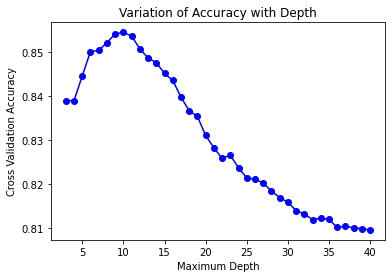

dict_items([(3, 0.8389722697143795), (4, 0.8390164808176914), (5, 0.8445889819661826), (6, 0.850161473335079), (7, 0.8504047309767933), (8, 0.8521957977570009), (9, 0.8541418955641958), (10, 0.8545399446328238), (11, 0.8536553607215775), (12, 0.850802733592346), (13, 0.8486798793882571), (14, 0.8476405871766529), (15, 0.8451859993364546), (16, 0.8436159416197307), (17, 0.8397903670501978), (18, 0.8366945238425301), (19, 0.835411937315731), (20, 0.8310777260192722), (21, 0.8282914289919512), (22, 0.8258590090483257), (23, 0.826610837404701), (24, 0.8237362648646783), (25, 0.821392181556222), (26, 0.8211489141349129), (27, 0.8202644475788047), (28, 0.8184512422408083), (29, 0.8169695627225316), (30, 0.8159081441776328), (31, 0.8139843193976553), (32, 0.8132324837065837), (33, 0.8119499925308343), (34, 0.8122816454852867), (35, 0.8119941962994502), (36, 0.8101589110812343), (37, 0.8104905591458893), (38, 0.810070410637852), (39, 0.8098934830980486), (40, 0.8096059996836301)])
The best dep

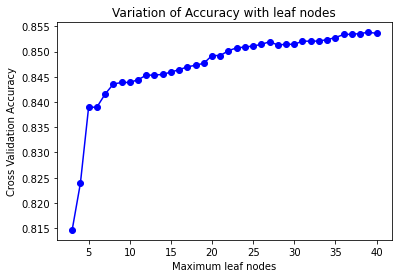

dict_items([(3, 0.814647798894368), (4, 0.8238911002997691), (5, 0.8389722697143795), (6, 0.8389722697143795), (7, 0.8415596204441451), (8, 0.8435497508770462), (9, 0.8438814258355869), (10, 0.8438814258355869), (11, 0.8444121277733402), (12, 0.84531878423011), (13, 0.8453408958940127), (14, 0.8454734803059741), (15, 0.8459378765908039), (16, 0.8464022630960388), (17, 0.8469771883615976), (18, 0.8472867858848174), (19, 0.847684812949357), (20, 0.8492106864566548), (21, 0.8492106864566548), (22, 0.8501836192275636), (23, 0.8507364254945236), (24, 0.8508912046969439), (25, 0.851112328670667), (26, 0.8514218895204063), (27, 0.8519526232418426), (28, 0.8513113849886642), (29, 0.8514440500822831), (30, 0.8514440549720804), (31, 0.8520632182348369), (32, 0.8520632182348369), (33, 0.8520853396783344), (34, 0.8523728230927528), (35, 0.852770845267495), (36, 0.853390006085353), (37, 0.8534342269682597), (38, 0.853566911621068), (39, 0.8538322515879007), (40, 0.8536111202794812)])
The best leaf 

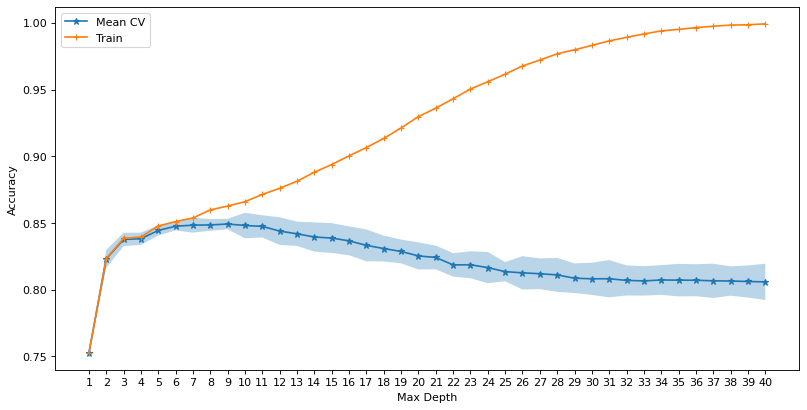

<Figure size 72x72 with 0 Axes>

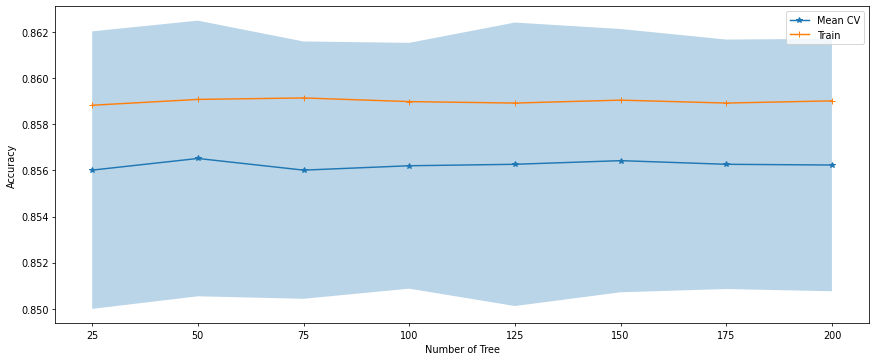

<Figure size 72x72 with 0 Axes>

In [112]:
# credit: https://harvard-iacs.github.io/2018-CS109A/pages/materials.html

# Python libraries 
import os
import time
import collections
import joblib
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

class Model:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.cat_ix = X.select_dtypes(include=['object', 'bool']).columns
        self.num_ix = X.select_dtypes(include=['int64', 'float64']).columns
        self.best_depth = 0
        self.best_leaf_node = 0

# optimal_depth_of_tree        
    def find_optimal_depth_of_tree(self):
        print('--optimal depth of tree--')
        depths = list(range(3, 41))
        depth_result = {}
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        start_time = time.time()
        for depth in depths:
            dtree = DecisionTreeClassifier(max_depth=depth, random_state=42)
            pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
            scores = cross_val_score(estimator=pipe, X=self.X, y=self.y, cv=5, n_jobs=-1)
            depth_result[depth] = scores.mean()

        time_elapsed = (time.time() - start_time)
        print("Computational time [optimal_depth_of_tree]:{}".format(time_elapsed))
        return depth_result
    
    # Perform 5-fold cross-validation to determine what the best max_depth
    def find_optimal_depth_of_tree_on_Xtrain(self):
        print('--optimal depth of tree on Xtrain feature set--')
        depths = list(range(1, 41))
        train_scores = []
        cvmeans = []
        cvstds = []
        cv_scores = []
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        for depth in depths:
            dtree = DecisionTreeClassifier(max_depth=depth, random_state=42)
            # wrap the model a pipeline
            pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
            # Perform 5-fold cross validation and store results
            train_scores.append(pipe.fit(X_train, y_train).score(X_train, y_train))
            scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=5)
            cvmeans.append(scores.mean())
            cvstds.append(scores.std())

        cvmeans = np.array(cvmeans)
        cvstds = np.array(cvstds)
        
        return depths, cvmeans, cvstds, train_scores
    
    # Visualize the results with mean & sd across the validation sets
    def plot_optimal_depth_of_tree_on_Xtrain(self, depths, cvmeans, cvstds, train_scores):
        from matplotlib.pyplot import figure
        figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
        plt.plot(depths, cvmeans, '*-', label="Mean CV")
        plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
        ylim = plt.ylim()
        plt.plot(depths, train_scores, '-+', label="Train")
        plt.legend()
        plt.ylabel("Accuracy")
        plt.xlabel("Max Depth")
        plt.xticks(depths);
        plt.figure(figsize=(1,1))
    
    def plot_optimal_depth_of_tree(self, depth):
        lists = sorted(depth.items())
        x, y = zip(*lists) 
        plt.ylabel("Cross Validation Accuracy")
        plt.xlabel("Maximum Depth")
        plt.title('Variation of Accuracy with Depth')
        plt.plot(x, y, 'b-', marker='o')
        plt.show()
    
    def evaluate_optimal_depth_of_tree(self, depth):
        # To find the optimal depth 
        print(depth.items())
        self.best_depth = sorted(depth, key=depth.get, reverse=True)[0]
        print("The best depth was found to be:", self.best_depth)
        
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        
        start_time = time.time()
        dtree = DecisionTreeClassifier(max_depth=self.best_depth, random_state=42)
        pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
        pipe.fit(X_train, y_train)
        time_elapsed = (time.time() - start_time)
        
        #Check Accuracy of income prediction in Train and Test Set
        print("Accuracy, Training Set: {:.2%}".format(metrics.accuracy_score(y_train, pipe.predict(X_train))))
        print("Accuracy, Testing Set: {:.2%}".format(metrics.accuracy_score(y_test, pipe.predict(X_test))))
        print("Computational time [evaluate_depth_of_tree]:{}".format(time_elapsed))
        
        #Get Performance by Class (Lookup Confusion Matrix)
        threshold = 0.5 # set threshold as 0.5
        y_pred = (pipe.predict_proba(X_test)[:,1] >= threshold).astype(int)
        print(pd.crosstab(y_test, y_pred, margins=True, rownames=['Actual'], colnames=['Predicted']))
        
        # Confusion Matrix
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        print(f"confusion matrix:\n {conf_mat}")
        
# optimal_leaf_nodes    
    def find_optimal_leaf_nodes(self):
        print('--optimal leaf nodes--')
        #Find optimal leaf nodes
        leaf_nodes = list(range(3, 41))
        leaf_nodes_result = {}
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        start_time = time.time()
        for leaf_node in leaf_nodes:
            dtree = DecisionTreeClassifier(max_depth=self.best_depth, max_leaf_nodes=leaf_node,random_state=42)
            pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
            scores = cross_val_score(estimator=pipe, X=self.X, y=self.y, cv=5, n_jobs=-1)
            leaf_nodes_result[leaf_node] = scores.mean()
        
        time_elapsed = (time.time() - start_time)
        print("Computational time [optimal_leaf_nodes]:{}".format(time_elapsed))
        return leaf_nodes_result
    
    def plot_optimal_leaf_nodes(self, leaf_nodes):
        lists = sorted(leaf_nodes.items())
        x, y = zip(*lists) 
        plt.ylabel("Cross Validation Accuracy")
        plt.xlabel("Maximum leaf nodes")
        plt.title('Variation of Accuracy with leaf nodes')
        plt.plot(x, y, 'b-', marker='o')
        plt.show()
        
    def evaluate_optimal_leaf_nodes(self, leaf_nodes):
        # To find the optimal leaf node 
        print(leaf_nodes.items())
        self.best_leaf_node = sorted(leaf_nodes, key=leaf_nodes.get, reverse=True)[0]
        print("The best leaf node was found to be:", self.best_leaf_node)
        
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        
        start_time = time.time()
        dtree = DecisionTreeClassifier(max_depth=self.best_depth, max_leaf_nodes=self.best_leaf_node, random_state=42)
        pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
        pipe.fit(X_train, y_train)
        time_elapsed = (time.time() - start_time)
        print("---parameter")
        print(f"best_depth: {self.best_depth}")
        print(f"best_leaf_node: {self.best_leaf_node}")
        
        #Check Accuracy of income prediction in Train and Test Set
        print("Accuracy, Training Set: {:.2%}".format(metrics.accuracy_score(y_train, pipe.predict(X_train))))
        print("Accuracy, Testing Set: {:.2%}".format(metrics.accuracy_score(y_test, pipe.predict(X_test))))
        print("Computational time [evaluate_optimal_leaf_nodes]:{}".format(time_elapsed))
        
        #Get Performance by Class (Lookup Confusion Matrix)
        threshold = 0.5 # set threshold as 0.5
        y_pred = (pipe.predict_proba(X_test)[:,1] >= threshold).astype(int)
        print(pd.crosstab(y_test, y_pred, margins=True, rownames=['Actual'], colnames=['Predicted']))
        
        # Confusion Matrix
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        print(f"confusion matrix:\n {conf_mat}")

# optimal_n_estimators        
# ensemble
    def find_optimal_n_estimators(self):
        print('--optimal n_estimators--')
        
        ntrees = list(range(25, 201, 25))
        print(f"ntrees: {ntrees}")
        train_scores = []
        cvmeans = []
        cvstds = []
        cv_scores = []
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        start_time = time.time()
        
        for tree in ntrees:
            clf  = DecisionTreeClassifier(max_leaf_nodes=self.best_leaf_node,
                                       criterion="gini", 
                                       max_depth=self.best_depth,
                                       random_state=42)
            
            bag = BaggingClassifier(base_estimator=clf,
                                    n_estimators=tree,
                                    oob_score=True,
                                    bootstrap=True,
                                    bootstrap_features=False,
                                    n_jobs=-1,
                                    random_state=42)
            
            pipe  = Pipeline(steps=[('transformer',ct),('bag',bag)])
            # Perform 5-fold cross validation and store results
            train_scores.append(pipe.fit(X_train, y_train).score(X_train, y_train))
            scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=5)
            cvmeans.append(scores.mean())
            cvstds.append(scores.std())

        cvmeans = np.array(cvmeans)
        cvstds = np.array(cvstds)
        
        time_elapsed = (time.time() - start_time)
        print("Computational time [optimal_leaf_nodes]:{}".format(time_elapsed))
        
        print("n_tree --> Training score --> cvmeans")
        for tree, train_score, cvmean in zip(list(ntrees), list(train_scores), list(cvmeans)):
            print(f"({tree} --> {train_score} --> {cvmean})")
    
        return ntrees, cvmeans, cvstds, train_scores
    
    def plot_optimal_n_estimators(self, ntrees, cvmeans, cvstds, train_scores):
        from matplotlib.pyplot import figure
        figure(num=None, figsize=(15, 6), dpi=70, facecolor='w', edgecolor='k')
        # plot means and shade the 2 SD interval
        plt.plot(ntrees, cvmeans, '*-', label="Mean CV")
        plt.fill_between(ntrees, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
        ylim = plt.ylim()
        plt.plot(ntrees, train_scores, '-+', label="Train")
        plt.legend()
        plt.ylabel("Accuracy")
        plt.xlabel("Number of Tree")
        plt.xticks(ntrees);
        plt.figure(figsize=(1,1))
        
if __name__ =='__main__':

    df = pd.read_csv("./data/adult.csv")
    
    #Prepocessing
    features = 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country'
    target = 'IncomeGroup'
    X = df[features.split()]
    y = df[target]
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    
    model = Model(X,y)
    
    #Find optimal depth of trees
    depth = model.find_optimal_depth_of_tree()
    model.plot_optimal_depth_of_tree(depth)
    model.evaluate_optimal_depth_of_tree(depth)
    
    #Find optimal leaf nodes
    leaf_nodes = model.find_optimal_leaf_nodes()
    model.plot_optimal_leaf_nodes(leaf_nodes)
    model.evaluate_optimal_leaf_nodes(leaf_nodes)
    
    #Find optimal depth of trees on Xtrain feature set
    depths, cvmeans, cvstds, train_scores = model.find_optimal_depth_of_tree_on_Xtrain()
    model.plot_optimal_depth_of_tree_on_Xtrain(depths, cvmeans, cvstds, train_scores)
    
    #Find optimal number of trees on Xtrain feature set
    ntrees, cvmeans, cvstds, train_scores = model.find_optimal_n_estimators()
    model.plot_optimal_n_estimators(ntrees, cvmeans, cvstds, train_scores)
    

<a id="3_2"></a>
##### 3.2 Submit the Training Job to the SageMaker Compute Cluster
- 3.2.1 [hardware info](#3_2_1)
- 3.2.2 [Model Training](#3_2_2)

<a id="3_2_1"></a>
###### 3.2.1 hardware info

In [ ]:
# Locally
#--------------------------------------------
# Python implementation: CPython
# Python version       : 3.6.10

# Compiler    : GCC 7.3.0
# OS          : Linux
# Release     : 4.14.200-116.320.amzn1.x86_64
# Machine     : x86_64
# Processor   : x86_64
# CPU cores   : 2
# Architecture: 64bit

# Hostname: ip-172-16-43-237
#--------------------------------------------

# Model Training hardware
# Python implementation: CPython
# Python version       : 3.7.9

# Compiler    : GCC 7.3.0
# OS          : Linux
# Release     : 4.14.203-116.332.amzn1.x86_64
# Machine     : x86_64
# Processor   : x86_64
# CPU cores   : 16
# Architecture: 64bit
# Hostname: ip-10-0-162-243.us-east-2.compute.internal
    

<a id="3_2_2"></a>
###### 3.2.2 Model Training

In [7]:
## Prepare a training script

# Directory to write training script: Code Directory
import os
script_folder = os.path.join(os.getcwd(), "script")
os.makedirs(script_folder, exist_ok=True)
print(script_folder)

/home/ec2-user/SageMaker/script


In [46]:
%%writefile $script_folder/train_dept_of_tree.py

# Python libraries 
import os
import argparse
import time
import collections
import joblib
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier


class Model:
    def __init__(self, X, y, file_path):
        self.X = X
        self.y = y
        self.cat_ix = X.select_dtypes(include=['object', 'bool']).columns
        self.num_ix = X.select_dtypes(include=['int64', 'float64']).columns
        self.file_path = file_path
        
    # optimal_depth_of_tree        
    def find_optimal_depth_of_tree(self):
        print('--optimal depth of tree--')
        depths = list(range(3, 41))
        depth_result = {}
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        start_time = time.time()
        for depth in depths:
            dtree = DecisionTreeClassifier(max_depth=depth, random_state=42)
            pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
            scores = cross_val_score(estimator=pipe, X=self.X, y=self.y, cv=5, n_jobs=-1)
            depth_result[depth] = scores.mean()

        time_elapsed = (time.time() - start_time)
        print("Computational time [optimal_depth_of_tree]:{}".format(time_elapsed))
        return depth_result
    
    # Perform 5-fold cross-validation to determine what the best max_depth
    def find_optimal_depth_of_tree_on_Xtrain(self):
        print('--optimal depth of tree on Xtrain feature set--')
        depths = list(range(1, 41))
        train_scores = []
        cvmeans = []
        cvstds = []
        cv_scores = []
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        for depth in depths:
            dtree = DecisionTreeClassifier(max_depth=depth, random_state=42)
            # wrap the model a pipeline
            pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
            # Perform 5-fold cross validation and store results
            train_scores.append(pipe.fit(X_train, y_train).score(X_train, y_train))
            scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=5)
            cvmeans.append(scores.mean())
            cvstds.append(scores.std())

        cvmeans = np.array(cvmeans)
        cvstds = np.array(cvstds)
        
        return depths, cvmeans, cvstds, train_scores
    
    # Visualize the results with mean & sd across the validation sets
    def plot_optimal_depth_of_tree_on_Xtrain(self, depths, cvmeans, cvstds, train_scores):
        from matplotlib.pyplot import figure
        figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
        plt.plot(depths, cvmeans, '*-', label="Mean CV")
        plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
        ylim = plt.ylim()
        plt.plot(depths, train_scores, '-+', label="Train")
        plt.legend()
        plt.ylabel("Accuracy")
        plt.xlabel("Max Depth")
        plt.xticks(depths);
        plt.savefig(f'{file_path}/depth_of_tree_Xtrain.png', dpi=300)
    
    def plot_optimal_depth_of_tree(self, depth):
        
        lists = sorted(depth.items())
        x, y = zip(*lists) 
        plt.ylabel("Cross Validation Accuracy")
        plt.xlabel("Maximum Depth")
        plt.title('Variation of Accuracy with Depth')
        plt.plot(x, y, 'b-', marker='o')
        plt.savefig(f'{file_path}/depth_of_tree.png', dpi=300)
    
    def evaluate_optimal_depth_of_tree(self, depth):
        # To find the optimal depth 
        print(depth.items())
        self.best_depth = sorted(depth, key=depth.get, reverse=True)[0]
        print("The best depth was found to be:", self.best_depth)
        
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)

        start_time = time.time()
        dtree = DecisionTreeClassifier(max_depth=self.best_depth, random_state=42)
        pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
        pipe.fit(X_train, y_train)
        time_elapsed = (time.time() - start_time)
        
        #Check Accuracy of income prediction in Train and Test Set
        print("Accuracy, Training Set: {:.2%}".format(metrics.accuracy_score(y_train, pipe.predict(X_train))))
        print("Accuracy, Testing Set: {:.2%}".format(metrics.accuracy_score(y_test, pipe.predict(X_test))))
        print("Computational time [evaluate_depth_of_tree]:{}".format(time_elapsed))
        
        #Get Performance by Class (Lookup Confusion Matrix)
        threshold = 0.5 # set threshold as 0.5
        y_pred = (pipe.predict_proba(X_test)[:,1] >= threshold).astype(int)
        print(pd.crosstab(y_test, y_pred, margins=True, rownames=['Actual'], colnames=['Predicted']))
        
        # Confusion Matrix
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        print(f"confusion matrix:\n {conf_mat}")
        

if __name__ =='__main__':
    
    parser = argparse.ArgumentParser()
    
    # Data, model, and output directories
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--features', type=str)  # required name features for flexibity
    parser.add_argument('--target', type=str, default='IncomeGroup')

    args, _ = parser.parse_known_args()
    print(f"train-dir: {args.train}")
    
    # Take the set of files and read them all into a single pandas dataframe
    input_files = [ os.path.join(args.train, file) for file in os.listdir(args.train) ]
    if len(input_files) == 0:
        raise ValueError(('There are no files in {}.\n' +
                          'This usually indicates that the channel ({}) was incorrectly specified,\n' +
                          'the data specification in S3 was incorrectly specified or the role specified\n' +
                          'does not have permission to access the data.').format(args.train, "train"))
    raw_data = [ pd.read_csv(file, engine="python") for file in input_files ]
    df = pd.concat(raw_data)
    print(f"df.shape:{df.shape}")
          
    #Prepocessing
    print('building datasets')
    X = df[args.features.split()]
    y = df[args.target]

    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    
    file_path = args.model_dir
    print(f"file_path: {file_path}")
    model = Model(X,y,file_path)
    
    #Find optimal depth of trees
    depth = model.find_optimal_depth_of_tree()
    #model.plot_optimal_depth_of_tree(depth)
    model.evaluate_optimal_depth_of_tree(depth)
    
    #Find optimal depth of trees on Xtrain feature set
    depths, cvmeans, cvstds, train_scores = model.find_optimal_depth_of_tree_on_Xtrain()
    #model.plot_optimal_depth_of_tree_on_Xtrain(depths, cvmeans, cvstds, train_scores)


Overwriting /home/ec2-user/SageMaker/script/train_dept_of_tree.py


In [34]:
! python $script_folder/train_dept_of_tree.py --features 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country' \
                   --model-dir ./ \
                   --train ./data/ 

df.shape:(45222, 15)
building datasets
file_path: ./
--optimal depth of tree--
Computational time [optimal_depth_of_tree]:148.05697679519653
dict_items([(3, 0.8389722697143795), (4, 0.8390164808176914), (5, 0.8445889819661826), (6, 0.850161473335079), (7, 0.8504047309767933), (8, 0.8521957977570009), (9, 0.8541418955641958), (10, 0.8545399446328238), (11, 0.8536553607215775), (12, 0.850802733592346), (13, 0.8486798793882571), (14, 0.8476405871766529), (15, 0.8451859993364546), (16, 0.8436159416197307), (17, 0.8397903670501978), (18, 0.8366945238425301), (19, 0.835411937315731), (20, 0.8310777260192722), (21, 0.8282914289919512), (22, 0.8258590090483257), (23, 0.826610837404701), (24, 0.8237362648646783), (25, 0.821392181556222), (26, 0.8211489141349129), (27, 0.8202644475788047), (28, 0.8184512422408083), (29, 0.8169695627225316), (30, 0.8159081441776328), (31, 0.8139843193976553), (32, 0.8132324837065837), (33, 0.8119499925308343), (34, 0.8122816454852867), (35, 0.8119941962994502), (

In [47]:
## Submit the Training Job to the Compute Cluster

# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn

sklearn_estimator = SKLearn(
    source_dir="./script/",
    entry_point='train_dept_of_tree.py',
    role = get_execution_role(),
    instance_type='ml.m5.4xlarge', 
    framework_version='0.20.0',
    base_job_name='binary-classifiation-scikit-cart',
    hyperparameters = {
                        'features': 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country'
                      })

## Call the estimator’s fit method

# launch training job, with asynchronous call
train_input = 's3://sagemaker-us-east-2-359732627051/Scikit-adults/data'
sklearn_estimator.fit({'train': train_input}, wait=False)

In [ ]:
# train_dept_of_tree.py
#Computational time [optimal_depth_of_tree]:55.183103799819946
#dict_items([(3, 0.8389721246802198), (4, 0.8390163406717068), (5, 0.8445889909957887), (6, 0.8501614921751012), (7, 0.8504046593452896), (8, 0.852195772587765), (9, 0.8541417946095887), (10, 0.8545398192276077), (11, 0.8536552891057549), (12, 0.8508025690454991), (13, 0.8486797735108682), (14, 0.8476404030538539), (15, 0.8451857638486127), (16, 0.8436157843670253), (17, 0.8397902195608655), (18, 0.8366942174050417), (19, 0.8354116039730017), (20, 0.831077329078355), (21, 0.8281362185956992), (22, 0.8259028891916232), (23, 0.8266547835743225), (24, 0.8235810544484196), (25, 0.821480370590128), (26, 0.8210379612593602), (27, 0.8201756308188453), (28, 0.8184729837927923), (29, 0.8171682366895171), (30, 0.8163058720166351), (31, 0.8139840568493837), (32, 0.8129667687061323), (33, 0.8117063549635409), (34, 0.8124582028839724), (35, 0.8118169597393743), (36, 0.8100258318318321), (37, 0.8102469435810619), (38, 0.8100700184829128), (39, 0.8098930909393239), (40, 0.8096941055282558)])
#The best depth was found to be: 10

#Computational time [evaluate_depth_of_tree]:0.37671375274658203
#Accuracy, Training Set: 86.60%
#Accuracy, Testing Set: 85.63%

Predicted      0     1    All
Actual
0           9596   597  10193
1           1359  2015   3374
All        10955  2612  13567

confusion matrix:
 [[9596  597]
 [1359 2015]]


In [54]:
%%writefile $script_folder/train_leaf_nodes.py

# Python libraries 
import os
import argparse
import time
import collections
import joblib
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier


class Model:
    def __init__(self, X, y, file_path):
        self.X = X
        self.y = y
        self.cat_ix = X.select_dtypes(include=['object', 'bool']).columns
        self.num_ix = X.select_dtypes(include=['int64', 'float64']).columns
        self.file_path = file_path
        
    # optimal_leaf_nodes        
    def find_optimal_leaf_nodes(self, best_depth):
        print('--optimal leaf nodes--')
        #Find optimal leaf nodes
        leaf_nodes = list(range(3, 41))
        leaf_nodes_result = {}
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        start_time = time.time()
        for leaf_node in leaf_nodes:
            dtree = DecisionTreeClassifier(max_depth=best_depth, max_leaf_nodes=leaf_node,random_state=42)
            pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
            scores = cross_val_score(estimator=pipe, X=self.X, y=self.y, cv=5, n_jobs=-1)
            leaf_nodes_result[leaf_node] = scores.mean()
        
        time_elapsed = (time.time() - start_time)
        print("Computational time [optimal_leaf_nodes]:{}".format(time_elapsed))
        return leaf_nodes_result
    
    def plot_optimal_leaf_nodes(self, leaf_nodes):
        lists = sorted(leaf_nodes.items())
        x, y = zip(*lists) 
        plt.ylabel("Cross Validation Accuracy")
        plt.xlabel("Maximum leaf nodes")
        plt.title('Variation of Accuracy with leaf nodes')
        plt.plot(x, y, 'b-', marker='o')
        plt.savefig(f'{file_path}/leaf_node.png', dpi=300)
    
    def evaluate_optimal_leaf_nodes(self, leaf_nodes, best_depth):
        # To find the optimal leaf node 
        print(leaf_nodes.items())
        best_leaf_node = sorted(leaf_nodes, key=leaf_nodes.get, reverse=True)[0]
        print("The best leaf node was found to be:", best_leaf_node)
        
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)

        start_time = time.time()
        dtree = DecisionTreeClassifier(max_depth=best_depth, max_leaf_nodes=best_leaf_node, random_state=42)
        pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
        pipe.fit(X_train, y_train)
        time_elapsed = (time.time() - start_time)
        print("---parameter")
        print(f"best_depth: {best_depth}")
        print(f"best_leaf_node: {best_leaf_node}")
        
        #Check Accuracy of income prediction in Train and Test Set
        print("Accuracy, Training Set: {:.2%}".format(metrics.accuracy_score(y_train, pipe.predict(X_train))))
        print("Accuracy, Testing Set: {:.2%}".format(metrics.accuracy_score(y_test, pipe.predict(X_test))))
        print("Computational time [evaluate_optimal_leaf_nodes]:{}".format(time_elapsed))
        
        #Get Performance by Class (Lookup Confusion Matrix)
        threshold = 0.5 # set threshold as 0.5
        y_pred = (pipe.predict_proba(X_test)[:,1] >= threshold).astype(int)
        print(pd.crosstab(y_test, y_pred, margins=True, rownames=['Actual'], colnames=['Predicted']))
        
        # Confusion Matrix
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        print(f"confusion matrix:\n {conf_mat}")
        

if __name__ =='__main__':
    
    parser = argparse.ArgumentParser()
    
    # Data, model, and output directories
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--features', type=str)  # required name features for flexibity
    parser.add_argument('--target', type=str, default='IncomeGroup')
    parser.add_argument('--best-depth', type=int)
    
    args, _ = parser.parse_known_args()
    print(f"best-depth: {args.best_depth}")
    
    # Take the set of files and read them all into a single pandas dataframe
    input_files = [ os.path.join(args.train, file) for file in os.listdir(args.train) ]
    if len(input_files) == 0:
        raise ValueError(('There are no files in {}.\n' +
                          'This usually indicates that the channel ({}) was incorrectly specified,\n' +
                          'the data specification in S3 was incorrectly specified or the role specified\n' +
                          'does not have permission to access the data.').format(args.train, "train"))
    raw_data = [ pd.read_csv(file, engine="python") for file in input_files ]
    df = pd.concat(raw_data)
    print(f"df.shape:{df.shape}")
          
    #Prepocessing
    print('building datasets')
    X = df[args.features.split()]
    y = df[args.target]

    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    
    file_path = args.model_dir
    print(f"file_path: {file_path}")
    model = Model(X,y,file_path)
    
    #Find optimal leaf nodes
    best_depth = args.best_depth
    print(f"best_depth:{best_depth}")
    leaf_nodes = model.find_optimal_leaf_nodes(best_depth)
    model.plot_optimal_leaf_nodes(leaf_nodes)
    model.evaluate_optimal_leaf_nodes(leaf_nodes,best_depth)

Overwriting /home/ec2-user/SageMaker/script/train_leaf_nodes.py


In [55]:
! python $script_folder/train_leaf_nodes.py --best-depth 10 \
                   --features 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country' \
                   --model-dir ./ \
                   --train ./data/

best-depth: 10
df.shape:(45222, 15)
building datasets
file_path: ./
best_depth:10
--optimal leaf nodes--
Computational time [optimal_leaf_nodes]:37.243335247039795
dict_items([(3, 0.814647798894368), (4, 0.8238911002997691), (5, 0.8389722697143795), (6, 0.8389722697143795), (7, 0.8415596204441451), (8, 0.8435497508770462), (9, 0.8438814258355869), (10, 0.8438814258355869), (11, 0.8444121277733402), (12, 0.84531878423011), (13, 0.8453408958940127), (14, 0.8454734803059741), (15, 0.8459378765908039), (16, 0.8464022630960388), (17, 0.8469771883615976), (18, 0.8472867858848174), (19, 0.847684812949357), (20, 0.8492106864566548), (21, 0.8492106864566548), (22, 0.8501836192275636), (23, 0.8507364254945236), (24, 0.8508912046969439), (25, 0.851112328670667), (26, 0.8514218895204063), (27, 0.8519526232418426), (28, 0.8513113849886642), (29, 0.8514440500822831), (30, 0.8514440549720804), (31, 0.8520632182348369), (32, 0.8520632182348369), (33, 0.8520853396783344), (34, 0.8523728230927528), (35,

In [61]:
## Submit the Training Job to the Compute Cluster

# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn

sklearn_estimator = SKLearn(
    source_dir="./script/",
    entry_point='train_leaf_nodes.py',
    role = get_execution_role(),
    instance_type='ml.m5.4xlarge', 
    framework_version='0.20.0',
    base_job_name='binary-classifiation-scikit-cart',
    hyperparameters = {
                        'best-depth': '10',
                        'features': 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country'
                      })

## Call the estimator’s fit method

# launch training job, with asynchronous call
train_input = 's3://sagemaker-us-east-2-359732627051/Scikit-adults/data'
sklearn_estimator.fit({'train': train_input}, wait=False)

In [ ]:
# train_leaf_nodes.py
# Computational time [optimal_leaf_nodes]:21.19389033317566
# dict_items([(3, 0.8146476855265534), (4, 0.8238909918687952), (5, 0.8389721246802198), (6, 0.8389721246802198), (7, 0.8415596123545936), (8, 0.8435496621058375), (9, 0.8438813370643782), (10, 0.8438813370643782), (11, 0.8444120610110863), (12, 0.8453186783494768), (13, 0.8453407900133796), (14, 0.8454734453257812), (15, 0.8459378562832475), (16, 0.8464022843609529), (17, 0.8469771876224232), (18, 0.8472868487238241), (19, 0.8476848733450872), (20, 0.8492106930646134), (21, 0.8492106930646134), (22, 0.8501836258355221), (23, 0.8507364149881911), (24, 0.8508911379514524), (25, 0.8511122619251758), (26, 0.8514218252198136), (27, 0.8514881602115217), (28, 0.851311369597401), (29, 0.8515988334526299), (30, 0.8514440224627412), (31, 0.8520631514969157), (32, 0.8520631514969157), (33, 0.8520852631608185), (34, 0.8521294864886239), (35, 0.8524170016937548), (36, 0.85305829129251), (37, 0.853412090141069), (38, 0.8535226582412587), (39, 0.8531688325004361), (40, 0.8533678521449527)])
# Given best_depth: 10
# The best leaf node was found to be: 38

# Computational time [evaluate_optimal_leaf_nodes]:0.2408466339111328
# Accuracy, Training Set: 85.85%
# Accuracy, Testing Set: 85.66%

Predicted      0     1    All
Actual                       
0           9519   674  10193
1           1271  2103   3374
All        10790  2777  13567

confusion matrix:
 [[9519  674]
 [1271 2103]]



In [59]:
%%writefile $script_folder/train_n_estimators.py

# Python libraries 
import os
import argparse
import time
import collections
import joblib
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier


class Model:
    def __init__(self, X, y, file_path):
        self.X = X
        self.y = y
        self.cat_ix = X.select_dtypes(include=['object', 'bool']).columns
        self.num_ix = X.select_dtypes(include=['int64', 'float64']).columns
        self.file_path = file_path
        
    # optimal_n_estimators
    def find_optimal_n_estimators(self, best_depth, best_leaf_node):
        print('--optimal n_estimators--')
        
        ntrees = list(range(25, 201, 25))
        print(f"ntrees: {ntrees}")
        train_scores = []
        cvmeans = []
        cvstds = []
        cv_scores = []
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        start_time = time.time()
        
        for tree in ntrees:
            clf  = DecisionTreeClassifier(max_leaf_nodes=best_leaf_node,
                                       criterion="gini", 
                                       max_depth=best_depth,
                                       random_state=42)
            
            bag = BaggingClassifier(base_estimator=clf,
                                    n_estimators=tree,
                                    oob_score=True,
                                    bootstrap=True,
                                    bootstrap_features=False,
                                    n_jobs=-1,
                                    random_state=42)
            
            pipe  = Pipeline(steps=[('transformer',ct),('bag',bag)])
            # Perform 5-fold cross validation and store results
            train_scores.append(pipe.fit(X_train, y_train).score(X_train, y_train))
            scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=5)
            cvmeans.append(scores.mean())
            cvstds.append(scores.std())

        cvmeans = np.array(cvmeans)
        cvstds = np.array(cvstds)
        
        time_elapsed = (time.time() - start_time)
        print("Computational time [optimal_leaf_nodes]:{}".format(time_elapsed))
        
        print("n_tree --> Training score --> cvmeans")
        for tree, train_score, cvmean in zip(list(ntrees), list(train_scores), list(cvmeans)):
            print(f"({tree} --> {train_score} --> {cvmean})")
    
        return ntrees, cvmeans, cvstds, train_scores
    
    def plot_optimal_n_estimators(self, ntrees, cvmeans, cvstds, train_scores):
        from matplotlib.pyplot import figure
        figure(num=None, figsize=(15, 6), dpi=70, facecolor='w', edgecolor='k')
        # plot means and shade the 2 SD interval
        plt.plot(ntrees, cvmeans, '*-', label="Mean CV")
        plt.fill_between(ntrees, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
        ylim = plt.ylim()
        plt.plot(ntrees, train_scores, '-+', label="Train")
        plt.legend()
        plt.ylabel("Accuracy")
        plt.xlabel("Number of Tree")
        plt.xticks(ntrees);
        plt.savefig(f'{file_path}/n_estimator.png', dpi=300)
        

if __name__ =='__main__':
    
    parser = argparse.ArgumentParser()
    
    # Data, model, and output directories
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--features', type=str)  # required name features for flexibity
    parser.add_argument('--target', type=str, default='IncomeGroup')
    parser.add_argument('--best-depth', type=int)
    parser.add_argument('--best-leaf-node', type=int)
    
    args, _ = parser.parse_known_args()
    print(f"--best-depth: {args.best_depth}")
    print(f"--best-leaf-node: {args.best_leaf_node}")
    
    # Take the set of files and read them all into a single pandas dataframe
    input_files = [ os.path.join(args.train, file) for file in os.listdir(args.train) ]
    if len(input_files) == 0:
        raise ValueError(('There are no files in {}.\n' +
                          'This usually indicates that the channel ({}) was incorrectly specified,\n' +
                          'the data specification in S3 was incorrectly specified or the role specified\n' +
                          'does not have permission to access the data.').format(args.train, "train"))
    raw_data = [ pd.read_csv(file, engine="python") for file in input_files ]
    df = pd.concat(raw_data)
    print(f"df.shape:{df.shape}")
          
    #Prepocessing
    print('building datasets')
    X = df[args.features.split()]
    y = df[args.target]

    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    
    file_path = args.model_dir
    print(f"file_path: {file_path}")
    model = Model(X,y,file_path)
    
    #Find optimal leaf nodes
    best_depth = args.best_depth
    best_leaf_node = args.best_leaf_node
    
    #Find optimal number of trees on Xtrain feature set
    ntrees, cvmeans, cvstds, train_scores = model.find_optimal_n_estimators(best_depth, best_leaf_node)
    model.plot_optimal_n_estimators(ntrees, cvmeans, cvstds, train_scores)

Overwriting /home/ec2-user/SageMaker/script/train_n_estimators.py


In [60]:
! python $script_folder/train_n_estimators.py --best-depth 10 \
                   --best-leaf-node 39 \
                   --features 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country' \
                   --model-dir ./ \
                   --train ./data/ 

--best-depth: 10
--best-leaf-node: 39
df.shape:(45222, 15)
building datasets
file_path: ./
--optimal n_estimators--
ntrees: [25, 50, 75, 100, 125, 150, 175, 200]
Computational time [optimal_leaf_nodes]:399.4837255477905
n_tree --> Training score --> cvmeans
(25 --> 0.8588216711419997 --> 0.8560732901595325)
(50 --> 0.8590743958300426 --> 0.8564839677776023)
(75 --> 0.8591375770020534 --> 0.856041699573527)
(100 --> 0.8590112146580319 --> 0.8562628336755648)
(125 --> 0.8589480334860211 --> 0.8561680619175485)
(150 --> 0.8590743958300426 --> 0.8564523771915971)
(175 --> 0.8590112146580319 --> 0.85629442426157)
(200 --> 0.8590112146580319 --> 0.8561996525035539)


In [62]:
## Submit the Training Job to the Compute Cluster

# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn

sklearn_estimator = SKLearn(
    source_dir="./script/",
    entry_point='train_n_estimators.py',
    role = get_execution_role(),
    instance_type='ml.m5.4xlarge', 
    framework_version='0.20.0',
    base_job_name='binary-classifiation-scikit-cart',
    hyperparameters = {
                         'best-depth' : '10',
                         'best-leaf-node' : '38',
                         'features': 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country'
                      })

## Call the estimator’s fit method

# launch training job, with asynchronous call
train_input = 's3://sagemaker-us-east-2-359732627051/Scikit-adults/data'
sklearn_estimator.fit({'train': train_input}, wait=False)

In [ ]:
# Computational time [optimal_leaf_nodes]:512.5468833446503
n_tree --> Training score --> cvmeans
(25 --> 0.860211656926236 --> 0.8558521596231199)
(50 --> 0.8600221134102037 --> 0.8571790291306657)
(75 --> 0.8605275627862897 --> 0.8568947088691559)
(100 --> 0.8603380192702574 --> 0.8569578800646678)
(125 --> 0.8604327910282735 --> 0.8568315576376762)
(150 --> 0.8598641604801769 --> 0.8571158828929522)
(175 --> 0.8596746169641447 --> 0.8570842823288716)
(200 --> 0.8595798452061286 --> 0.8571159028538317)

<a id="3_3"></a>
##### 3.3 Submit the Training Job to the AMSL Compute Cluster

- 3.3.1 [hardware info](#3_3_1)
- 3.3.2 [Model Training](#3_3_2)

Notebook Instance

In [5]:
#! pip install watermark
%reload_ext watermark
%watermark  -d -u -h -m -v -p numpy,pandas,scipy,sklearn


last updated: 2020-12-14 

CPython 3.6.9
IPython 7.16.1

numpy 1.18.5
pandas 0.25.3
scipy 1.5.2
sklearn 0.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-1100-azure
machine    : x86_64
processor  : x86_64
CPU cores  : 1
interpreter: 64bit
host name  : cpu-standard-ds1v2


--optimal depth of tree--
Computational time [optimal_depth_of_tree]:554.976931810379
dict_items([(3, 0.8389722697143795), (4, 0.8390164808176914), (5, 0.8445889819661826), (6, 0.850161473335079), (7, 0.8504047309767933), (8, 0.8521957977570009), (9, 0.8541418955641958), (10, 0.8545399446328238), (11, 0.8536553607215775), (12, 0.850802733592346), (13, 0.8486798793882571), (14, 0.8476405871766529), (15, 0.8451859993364546), (16, 0.8436159416197307), (17, 0.8397903670501978), (18, 0.8366945238425301), (19, 0.835411937315731), (20, 0.8310777260192722), (21, 0.8282914289919512), (22, 0.8258590090483257), (23, 0.826610837404701), (24, 0.8237362648646783), (25, 0.821392181556222), (26, 0.8211489141349129), (27, 0.8202644475788047), (28, 0.8184512422408083), (29, 0.8169695627225316), (30, 0.8159081441776328), (31, 0.8139843193976553), (32, 0.8132324837065837), (33, 0.8119499925308343), (34, 0.8122816454852867), (35, 0.8119941962994502), (36, 0.8101589110812343), (37, 0.8104905591458893), (38,

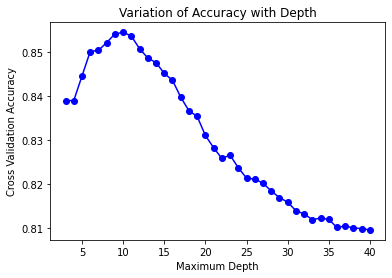

Accuracy, Training Set: 86.60%
Accuracy, Testing Set: 85.63%
Computational time [evaluate_depth_of_tree]:0.8807802200317383
Predicted      0     1    All
Actual                       
0           9596   597  10193
1           1359  2015   3374
All        10955  2612  13567
confusion matrix:
 [[9596  597]
 [1359 2015]]
--optimal leaf nodes--
Computational time [optimal_leaf_nodes]:146.7857310771942


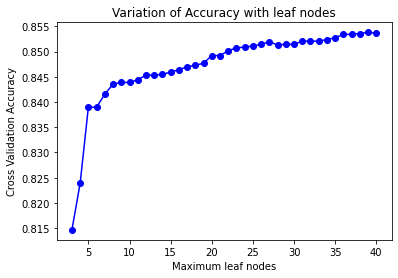

dict_items([(3, 0.814647798894368), (4, 0.8238911002997691), (5, 0.8389722697143795), (6, 0.8389722697143795), (7, 0.8415596204441451), (8, 0.8435497508770462), (9, 0.8438814258355869), (10, 0.8438814258355869), (11, 0.8444121277733402), (12, 0.84531878423011), (13, 0.8453408958940127), (14, 0.8454734803059741), (15, 0.8459378765908039), (16, 0.8464022630960388), (17, 0.8469771883615976), (18, 0.8472867858848174), (19, 0.847684812949357), (20, 0.8492106864566548), (21, 0.8492106864566548), (22, 0.8501836192275636), (23, 0.8507364254945236), (24, 0.8508912046969439), (25, 0.851112328670667), (26, 0.8514218895204063), (27, 0.8519526232418426), (28, 0.8513113849886642), (29, 0.8514440500822831), (30, 0.8514440549720804), (31, 0.8520632182348369), (32, 0.8520632182348369), (33, 0.8520853396783344), (34, 0.8523728230927528), (35, 0.852770845267495), (36, 0.853390006085353), (37, 0.8534342269682597), (38, 0.853566911621068), (39, 0.8538322515879007), (40, 0.8536111202794812)])
The best leaf 

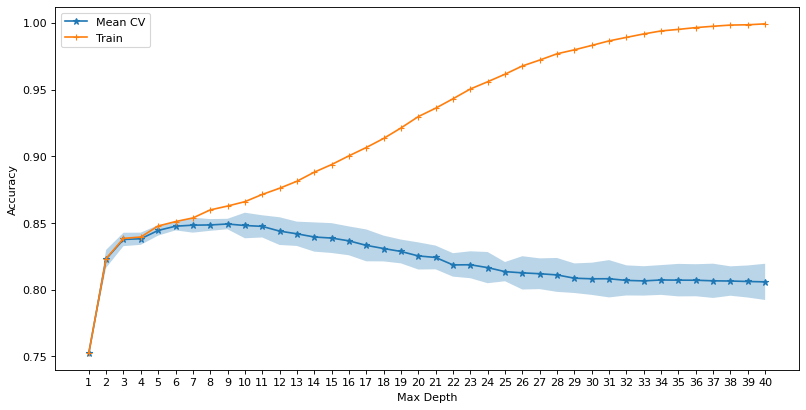

<Figure size 72x72 with 0 Axes>

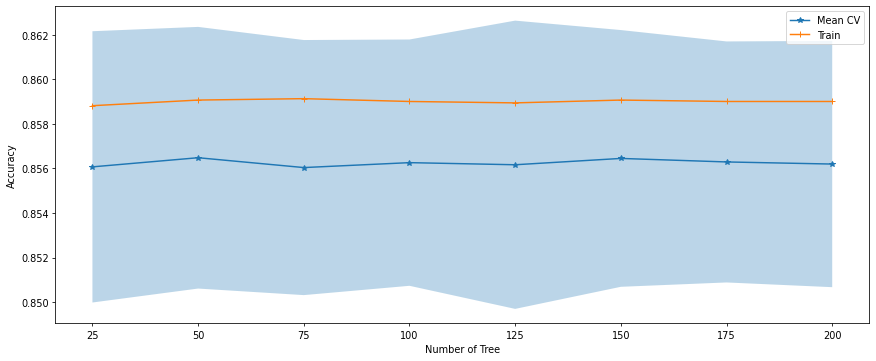

<Figure size 72x72 with 0 Axes>

In [14]:
# Python libraries 
import os
import time
import collections
import joblib
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

class Model:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.cat_ix = X.select_dtypes(include=['object', 'bool']).columns
        self.num_ix = X.select_dtypes(include=['int64', 'float64']).columns
        self.best_depth = 0
        self.best_leaf_node = 0

# optimal_depth_of_tree        
    def find_optimal_depth_of_tree(self):
        print('--optimal depth of tree--')
        depths = list(range(3, 41))
        depth_result = {}
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        start_time = time.time()
        for depth in depths:
            dtree = DecisionTreeClassifier(max_depth=depth, random_state=42)
            pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
            scores = cross_val_score(estimator=pipe, X=self.X, y=self.y, cv=5, n_jobs=-1)
            depth_result[depth] = scores.mean()

        time_elapsed = (time.time() - start_time)
        print("Computational time [optimal_depth_of_tree]:{}".format(time_elapsed))
        return depth_result
    
    # Perform 5-fold cross-validation to determine what the best max_depth
    def find_optimal_depth_of_tree_on_Xtrain(self):
        print('--optimal depth of tree on Xtrain feature set--')
        depths = list(range(1, 41))
        train_scores = []
        cvmeans = []
        cvstds = []
        cv_scores = []
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        for depth in depths:
            dtree = DecisionTreeClassifier(max_depth=depth, random_state=42)
            # wrap the model a pipeline
            pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
            # Perform 5-fold cross validation and store results
            train_scores.append(pipe.fit(X_train, y_train).score(X_train, y_train))
            scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=5)
            cvmeans.append(scores.mean())
            cvstds.append(scores.std())

        cvmeans = np.array(cvmeans)
        cvstds = np.array(cvstds)
        
        return depths, cvmeans, cvstds, train_scores
    
    # Visualize the results with mean & sd across the validation sets
    def plot_optimal_depth_of_tree_on_Xtrain(self, depths, cvmeans, cvstds, train_scores):
        from matplotlib.pyplot import figure
        figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
        plt.plot(depths, cvmeans, '*-', label="Mean CV")
        plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
        ylim = plt.ylim()
        plt.plot(depths, train_scores, '-+', label="Train")
        plt.legend()
        plt.ylabel("Accuracy")
        plt.xlabel("Max Depth")
        plt.xticks(depths);
        plt.figure(figsize=(1,1))
    
    def plot_optimal_depth_of_tree(self, depth):
        lists = sorted(depth.items())
        x, y = zip(*lists) 
        plt.ylabel("Cross Validation Accuracy")
        plt.xlabel("Maximum Depth")
        plt.title('Variation of Accuracy with Depth')
        plt.plot(x, y, 'b-', marker='o')
        plt.show()
    
    def evaluate_optimal_depth_of_tree(self, depth):
        # To find the optimal depth 
        print(depth.items())
        self.best_depth = sorted(depth, key=depth.get, reverse=True)[0]
        print("The best depth was found to be:", self.best_depth)
        
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)

        start_time = time.time()
        dtree = DecisionTreeClassifier(max_depth=self.best_depth, random_state=42)
        pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
        pipe.fit(X_train, y_train)
        time_elapsed = (time.time() - start_time)
        
        #Check Accuracy of income prediction in Train and Test Set
        print("Accuracy, Training Set: {:.2%}".format(metrics.accuracy_score(y_train, pipe.predict(X_train))))
        print("Accuracy, Testing Set: {:.2%}".format(metrics.accuracy_score(y_test, pipe.predict(X_test))))
        print("Computational time [evaluate_depth_of_tree]:{}".format(time_elapsed))
        
        #Get Performance by Class (Lookup Confusion Matrix)
        threshold = 0.5 # set threshold as 0.5
        y_pred = (pipe.predict_proba(X_test)[:,1] >= threshold).astype(int)
        print(pd.crosstab(y_test, y_pred, margins=True, rownames=['Actual'], colnames=['Predicted']))
        
        # Confusion Matrix
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        print(f"confusion matrix:\n {conf_mat}")
        
# optimal_leaf_nodes    
    def find_optimal_leaf_nodes(self):
        print('--optimal leaf nodes--')
        #Find optimal leaf nodes
        leaf_nodes = list(range(3, 41))
        leaf_nodes_result = {}
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        start_time = time.time()
        for leaf_node in leaf_nodes:
            dtree = DecisionTreeClassifier(max_depth=self.best_depth, max_leaf_nodes=leaf_node,random_state=42)
            pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
            scores = cross_val_score(estimator=pipe, X=self.X, y=self.y, cv=5, n_jobs=-1)
            leaf_nodes_result[leaf_node] = scores.mean()
        
        time_elapsed = (time.time() - start_time)
        print("Computational time [optimal_leaf_nodes]:{}".format(time_elapsed))
        return leaf_nodes_result
    
    def plot_optimal_leaf_nodes(self, leaf_nodes):
        lists = sorted(leaf_nodes.items())
        x, y = zip(*lists) 
        plt.ylabel("Cross Validation Accuracy")
        plt.xlabel("Maximum leaf nodes")
        plt.title('Variation of Accuracy with leaf nodes')
        plt.plot(x, y, 'b-', marker='o')
        plt.show()
        
    def evaluate_optimal_leaf_nodes(self, leaf_nodes):
        # To find the optimal leaf node 
        print(leaf_nodes.items())
        self.best_leaf_node = sorted(leaf_nodes, key=leaf_nodes.get, reverse=True)[0]
        print("The best leaf node was found to be:", self.best_leaf_node)
        
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)

        start_time = time.time()
        dtree = DecisionTreeClassifier(max_depth=self.best_depth, max_leaf_nodes=self.best_leaf_node, random_state=42)
        pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
        pipe.fit(X_train, y_train)
        time_elapsed = (time.time() - start_time)
        print("---parameter")
        print(f"best_depth: {self.best_depth}")
        print(f"best_leaf_node: {self.best_leaf_node}")
        
        #Check Accuracy of income prediction in Train and Test Set
        print("Accuracy, Training Set: {:.2%}".format(metrics.accuracy_score(y_train, pipe.predict(X_train))))
        print("Accuracy, Testing Set: {:.2%}".format(metrics.accuracy_score(y_test, pipe.predict(X_test))))
        print("Computational time [evaluate_optimal_leaf_nodes]:{}".format(time_elapsed))
        
        #Get Performance by Class (Lookup Confusion Matrix)
        threshold = 0.5 # set threshold as 0.5
        y_pred = (pipe.predict_proba(X_test)[:,1] >= threshold).astype(int)
        print(pd.crosstab(y_test, y_pred, margins=True, rownames=['Actual'], colnames=['Predicted']))
        
        # Confusion Matrix
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        print(f"confusion matrix:\n {conf_mat}")

# optimal_n_estimators        
# ensemble
    def find_optimal_n_estimators(self):
        print('--optimal n_estimators--')
        
        ntrees = list(range(25, 201, 25))
        print(f"ntrees: {ntrees}")
        train_scores = []
        cvmeans = []
        cvstds = []
        cv_scores = []
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        start_time = time.time()
        
        for tree in ntrees:
            clf  = DecisionTreeClassifier(max_leaf_nodes=self.best_leaf_node,
                                       criterion="gini", 
                                       max_depth=self.best_depth,
                                       random_state=42)
            
            bag = BaggingClassifier(base_estimator=clf,
                                    n_estimators=tree,
                                    oob_score=True,
                                    bootstrap=True,
                                    bootstrap_features=False,
                                    n_jobs=-1,
                                    random_state=42)
            
            pipe  = Pipeline(steps=[('transformer',ct),('bag',bag)])
            # Perform 5-fold cross validation and store results
            train_scores.append(pipe.fit(X_train, y_train).score(X_train, y_train))
            scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=5)
            cvmeans.append(scores.mean())
            cvstds.append(scores.std())

        cvmeans = np.array(cvmeans)
        cvstds = np.array(cvstds)
        
        time_elapsed = (time.time() - start_time)
        print("Computational time [optimal_leaf_nodes]:{}".format(time_elapsed))
        
        print("n_tree --> Training score --> cvmeans")
        for tree, train_score, cvmean in zip(list(ntrees), list(train_scores), list(cvmeans)):
            print(f"({tree} --> {train_score} --> {cvmean})")
    
        return ntrees, cvmeans, cvstds, train_scores
    
    def plot_optimal_n_estimators(self, ntrees, cvmeans, cvstds, train_scores):
        from matplotlib.pyplot import figure
        figure(num=None, figsize=(15, 6), dpi=70, facecolor='w', edgecolor='k')
        # plot means and shade the 2 SD interval
        plt.plot(ntrees, cvmeans, '*-', label="Mean CV")
        plt.fill_between(ntrees, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
        ylim = plt.ylim()
        plt.plot(ntrees, train_scores, '-+', label="Train")
        plt.legend()
        plt.ylabel("Accuracy")
        plt.xlabel("Number of Tree")
        plt.xticks(ntrees);
        plt.figure(figsize=(1,1))
        
if __name__ =='__main__':

    df = pd.read_csv("./data/adult.csv")
    
    #Prepocessing
    features = 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country'
    target = 'IncomeGroup'
    X = df[features.split()]
    y = df[target]
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    
    model = Model(X,y)
    
    #Find optimal depth of trees
    depth = model.find_optimal_depth_of_tree()
    model.plot_optimal_depth_of_tree(depth)
    model.evaluate_optimal_depth_of_tree(depth)
    
    #Find optimal leaf nodes
    leaf_nodes = model.find_optimal_leaf_nodes()
    model.plot_optimal_leaf_nodes(leaf_nodes)
    model.evaluate_optimal_leaf_nodes(leaf_nodes)
    
    #Find optimal depth of trees on Xtrain feature set
    depths, cvmeans, cvstds, train_scores = model.find_optimal_depth_of_tree_on_Xtrain()
    model.plot_optimal_depth_of_tree_on_Xtrain(depths, cvmeans, cvstds, train_scores)
    
    #Find optimal number of trees on Xtrain feature set
    ntrees, cvmeans, cvstds, train_scores = model.find_optimal_n_estimators()
    model.plot_optimal_n_estimators(ntrees, cvmeans, cvstds, train_scores)

<a id="3.3_1"></a>
###### 3.3.1 hardware info

In [ ]:
# Virtual machine size: STANDARD_D1_V2 (1 Cores, 3.5 GB RAM, 50 GB Disk)
# Processing Unit: CPU - General purpose
# Virtual machine priority: Dedicated
# Minimum number of nodes: 1
# Maximum number of nodes: 2

<a id="3_3_2"></a>
###### 3.3.2 Model Training

In [4]:
# Directory to write training script.
# Code Directory
import os
script_folder = os.path.join(os.getcwd(), "script")
os.makedirs(script_folder, exist_ok=True)
print(script_folder)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/cpu-standardds1v2/code/Users/877159/script


In [13]:
%%writefile $script_folder/train_depth_of_tree.py

# Python libraries 
import os
import time
import collections
import joblib
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from azureml.core import Run, Dataset

class Model:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.cat_ix = X.select_dtypes(include=['object', 'bool']).columns
        self.num_ix = X.select_dtypes(include=['int64', 'float64']).columns
        self.best_depth = 0
        self.best_leaf_node = 0
        

# optimal_depth_of_tree        
    def find_optimal_depth_of_tree(self):
        print('--optimal depth of tree--')
        depths = list(range(3, 41))
        depth_result = {}
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        start_time = time.time()
        for depth in depths:
            dtree = DecisionTreeClassifier(max_depth=depth, random_state=42)
            pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
            scores = cross_val_score(estimator=pipe, X=self.X, y=self.y, cv=5, n_jobs=-1)
            depth_result[depth] = scores.mean()

        time_elapsed = (time.time() - start_time)
        print("Computational time [optimal_depth_of_tree]:{}".format(time_elapsed))
        
        return depth_result
    
    # Perform 5-fold cross-validation to determine what the best max_depth
    def find_optimal_depth_of_tree_on_Xtrain(self):
        print('--optimal depth of tree on Xtrain feature set--')
        depths = list(range(1, 41))
        train_scores = []
        cvmeans = []
        cvstds = []
        cv_scores = []
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        for depth in depths:
            dtree = DecisionTreeClassifier(max_depth=depth, random_state=42)
            # wrap the model a pipeline
            pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
            # Perform 5-fold cross validation and store results
            train_scores.append(pipe.fit(X_train, y_train).score(X_train, y_train))
            scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=5)
            cvmeans.append(scores.mean())
            cvstds.append(scores.std())

        cvmeans = np.array(cvmeans)
        cvstds = np.array(cvstds)
        
        return depths, cvmeans, cvstds, train_scores
    
    # Visualize the results with mean & sd across the validation sets
    def plot_optimal_depth_of_tree_on_Xtrain(self, depths, cvmeans, cvstds, train_scores, run):
        import matplotlib
        import matplotlib.pyplot as plt
        # from matplotlib.pyplot import figure
        # figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
        plt.plot(depths, cvmeans, '*-', label="Mean CV")
        plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
        ylim = plt.ylim()
        plt.plot(depths, train_scores, '-+', label="Train")
        plt.legend()
        plt.ylabel("Accuracy")
        plt.xlabel("Max Depth")
        plt.xticks(depths);
        plt.show()
        run.log_image('depth_X', plot=plt)
    
    def evaluate_optimal_depth_of_tree(self, depth):
        # To find the optimal depth 
        print(depth.items())
        self.best_depth = sorted(depth, key=depth.get, reverse=True)[0]
        print("The best depth was found to be:", self.best_depth)
        
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)

        start_time = time.time()
        dtree = DecisionTreeClassifier(max_depth=self.best_depth, random_state=42)
        pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
        pipe.fit(X_train, y_train)
        time_elapsed = (time.time() - start_time)
        
        #Check Accuracy of income prediction in Train and Test Set
        print("Accuracy, Training Set: {:.2%}".format(metrics.accuracy_score(y_train, pipe.predict(X_train))))
        print("Accuracy, Testing Set: {:.2%}".format(metrics.accuracy_score(y_test, pipe.predict(X_test))))
        print("Computational time [evaluate_depth_of_tree]:{}".format(time_elapsed))
        
        #Get Performance by Class (Lookup Confusion Matrix)
        threshold = 0.5 # set threshold as 0.5
        y_pred = (pipe.predict_proba(X_test)[:,1] >= threshold).astype(int)
        print(pd.crosstab(y_test, y_pred, margins=True, rownames=['Actual'], colnames=['Predicted']))
        
        # Confusion Matrix
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        run.log('conf_mat:', conf_mat)
        print(f"confusion matrix:\n {conf_mat}")
        
    def plot_optimal_depth_of_tree(self, depth, run):
        import matplotlib
        import matplotlib.pyplot as plt
        lists = sorted(depth.items())
        x, y = zip(*lists) 
        plt.ylabel("Cross Validation Accuracy")
        plt.xlabel("Maximum Depth")
        plt.title('Variation of Accuracy with Depth')
        plt.plot(x, y, 'b-', marker='o')
        plt.show()
        run.log_image('depth', plot=plt)

        
if __name__ =='__main__':
    os.makedirs('outputs', exist_ok=True)
    run = Run.get_context()

    dataset_name = 'adult-dataset'
    print("Loading data from " + dataset_name)
    df = Dataset.get_by_name(workspace=run.experiment.workspace, name=dataset_name).to_pandas_dataframe()

    #Prepocessing
    features = 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country'
    target = 'IncomeGroup'
    X = df[features.split()]
    y = df[target]
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    
    model = Model(X,y)
    
    #Find optimal depth of trees
    
    depth = model.find_optimal_depth_of_tree()
    #model.plot_optimal_depth_of_tree(depth,run)
    model.evaluate_optimal_depth_of_tree(depth)
    
    #Find optimal depth of trees on Xtrain feature set
    depths, cvmeans, cvstds, train_scores = model.find_optimal_depth_of_tree_on_Xtrain()
    model.plot_optimal_depth_of_tree_on_Xtrain(depths, cvmeans, cvstds, train_scores,run)

    

Overwriting /mnt/batch/tasks/shared/LS_root/mounts/clusters/cpu-standardds1v2/code/Users/877159/script/train_depth_of_tree.py


In [15]:
%%writefile $script_folder/train_leaf_nodes.py

# Python libraries 
import os
import time
import collections
import joblib
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from azureml.core import Run, Dataset

class Model:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.cat_ix = X.select_dtypes(include=['object', 'bool']).columns
        self.num_ix = X.select_dtypes(include=['int64', 'float64']).columns

# optimal_leaf_nodes    
    def find_optimal_leaf_nodes(self, best_depth):
        print('--optimal leaf nodes--')
        #Find optimal leaf nodes
        leaf_nodes = list(range(3, 41))
        leaf_nodes_result = {}
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        start_time = time.time()
        for leaf_node in leaf_nodes:
            dtree = DecisionTreeClassifier(max_depth=best_depth, max_leaf_nodes=leaf_node,random_state=42)
            pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
            scores = cross_val_score(estimator=pipe, X=self.X, y=self.y, cv=5, n_jobs=-1)
            leaf_nodes_result[leaf_node] = scores.mean()
        
        time_elapsed = (time.time() - start_time)
        print("Computational time [optimal_leaf_nodes]:{}".format(time_elapsed))
        return leaf_nodes_result
    
    def plot_optimal_leaf_nodes(self, leaf_nodes, run):
        import matplotlib
        import matplotlib.pyplot as plt
        lists = sorted(leaf_nodes.items())
        x, y = zip(*lists) 
        plt.ylabel("Cross Validation Accuracy")
        plt.xlabel("Maximum leaf nodes")
        plt.title('Variation of Accuracy with leaf nodes')
        plt.plot(x, y, 'b-', marker='o')
        plt.show()
        run.log_image('nodes', plot=plt)
        
        
    def evaluate_optimal_leaf_nodes(self, leaf_nodes,best_depth):
        # To find the optimal leaf node 
        print(leaf_nodes.items())
        best_leaf_node = sorted(leaf_nodes, key=leaf_nodes.get, reverse=True)[0]
        print("The best leaf node was found to be:", best_leaf_node)
        
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)

        start_time = time.time()
        dtree = DecisionTreeClassifier(max_depth=best_depth, max_leaf_nodes=best_leaf_node, random_state=42)
        pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
        pipe.fit(X_train, y_train)
        time_elapsed = (time.time() - start_time)
        print("---parameter")
        print(f"best_depth: {best_depth}")
        print(f"best_leaf_node: {best_leaf_node}")
        
        #Check Accuracy of income prediction in Train and Test Set
        print("Accuracy, Training Set: {:.2%}".format(metrics.accuracy_score(y_train, pipe.predict(X_train))))
        print("Accuracy, Testing Set: {:.2%}".format(metrics.accuracy_score(y_test, pipe.predict(X_test))))
        print("Computational time [evaluate_optimal_leaf_nodes]:{}".format(time_elapsed))
        
        #Get Performance by Class (Lookup Confusion Matrix)
        threshold = 0.5 # set threshold as 0.5
        y_pred = (pipe.predict_proba(X_test)[:,1] >= threshold).astype(int)
        print(pd.crosstab(y_test, y_pred, margins=True, rownames=['Actual'], colnames=['Predicted']))
        
        # Confusion Matrix
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        print(f"confusion matrix:\n {conf_mat}")


        
if __name__ =='__main__':
    os.makedirs('outputs', exist_ok=True)
    run = Run.get_context()

    dataset_name = 'adult-dataset'
    print("Loading data from " + dataset_name)
    df = Dataset.get_by_name(workspace=run.experiment.workspace, name=dataset_name).to_pandas_dataframe()

    #Prepocessing
    features = 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country'
    target = 'IncomeGroup'
    X = df[features.split()]
    y = df[target]
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    
    model = Model(X,y)
    
    #Find optimal leaf nodes
    best_depth = 10
    leaf_nodes = model.find_optimal_leaf_nodes(best_depth)
    model.plot_optimal_leaf_nodes(leaf_nodes,run)
    model.evaluate_optimal_leaf_nodes(leaf_nodes,best_depth)

Writing /mnt/batch/tasks/shared/LS_root/mounts/clusters/cpu-standardds1v2/code/Users/877159/script/train_leaf_nodes.py


In [17]:
%%writefile $script_folder/train_n_estimators.py

# Python libraries 
import os
import time
import collections
import joblib
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from azureml.core import Run, Dataset

class Model:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.cat_ix = X.select_dtypes(include=['object', 'bool']).columns
        self.num_ix = X.select_dtypes(include=['int64', 'float64']).columns

# optimal_n_estimators        
# ensemble
    def find_optimal_n_estimators(self, best_depth, best_leaf_node):
        print('--optimal n_estimators--')
        
        ntrees = list(range(25, 201, 25))
        print(f"ntrees: {ntrees}")
        train_scores = []
        cvmeans = []
        cvstds = []
        cv_scores = []
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        start_time = time.time()
        
        for tree in ntrees:
            clf  = DecisionTreeClassifier(max_leaf_nodes=best_leaf_node,
                                       criterion="gini", 
                                       max_depth=best_depth,
                                       random_state=42)
            
            bag = BaggingClassifier(base_estimator=clf,
                                    n_estimators=tree,
                                    oob_score=True,
                                    bootstrap=True,
                                    bootstrap_features=False,
                                    n_jobs=-1,
                                    random_state=42)
            
            pipe  = Pipeline(steps=[('transformer',ct),('bag',bag)])
            # Perform 5-fold cross validation and store results
            train_scores.append(pipe.fit(X_train, y_train).score(X_train, y_train))
            scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=5)
            cvmeans.append(scores.mean())
            cvstds.append(scores.std())

        cvmeans = np.array(cvmeans)
        cvstds = np.array(cvstds)
        
        time_elapsed = (time.time() - start_time)
        print("Computational time [optimal_leaf_nodes]:{}".format(time_elapsed))
        
        print("n_tree --> Training score --> cvmeans")
        for tree, train_score, cvmean in zip(list(ntrees), list(train_scores), list(cvmeans)):
            print(f"({tree} --> {train_score} --> {cvmean})")
    
        return ntrees, cvmeans, cvstds, train_scores
    
    def plot_optimal_n_estimators(self, ntrees, cvmeans, cvstds, train_scores, run):
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.pyplot import figure
        figure(num=None, figsize=(15, 6), dpi=70, facecolor='w', edgecolor='k')
        # plot means and shade the 2 SD interval
        plt.plot(ntrees, cvmeans, '*-', label="Mean CV")
        plt.fill_between(ntrees, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
        ylim = plt.ylim()
        plt.plot(ntrees, train_scores, '-+', label="Train")
        plt.legend()
        plt.ylabel("Accuracy")
        plt.xlabel("Number of Tree")
        plt.xticks(ntrees);
        plt.show()
        # plt.figure(figsize=(1,1))
        run.log_image('n_estimator', plot=plt)
  

        
if __name__ =='__main__':
    os.makedirs('outputs', exist_ok=True)
    run = Run.get_context()

    dataset_name = 'adult-dataset'
    print("Loading data from " + dataset_name)
    df = Dataset.get_by_name(workspace=run.experiment.workspace, name=dataset_name).to_pandas_dataframe()

    #Prepocessing
    features = 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country'
    target = 'IncomeGroup'
    X = df[features.split()]
    y = df[target]
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    
    model = Model(X,y)
    
    #Find optimal leaf nodes
    best_depth = 10
    best_leaf_node = 39
    
    #Find optimal number of trees on Xtrain feature set
    ntrees, cvmeans, cvstds, train_scores = model.find_optimal_n_estimators(best_depth, best_leaf_node)
    model.plot_optimal_n_estimators(ntrees, cvmeans, cvstds, train_scores,run)
    

Writing /mnt/batch/tasks/shared/LS_root/mounts/clusters/cpu-standardds1v2/code/Users/877159/script/train_n_estimators.py


In [6]:
# Initialize an Experiment.
experiment_name = 'Exp-3'

from azureml.core import Experiment
experiment = Experiment(workspace=ws, name=experiment_name)
print(f"Experiment: {experiment.name}")

Experiment: Exp-3


In [7]:
# Initialize dataset
from azureml.core import Dataset

ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)

#Create a tabular dataset from the path on the datastore (this may take a short while)
data_set = Dataset.Tabular.from_delimited_files(path=(ds, 'adults-data/adult.csv'))

# Register the dataset
dataset_name = 'adult-dataset'
data_set = data_set.register(workspace=ws, 
                           name=dataset_name,
                           description='UCI Adult "Census Income" dataset',
                           tags = {'Number of Instances':'45222',
                                   'Number of Attributes':'14'},
                           create_new_version=True)

# List the datasets registered in the workspace
for ds in ws.datasets:
    print(ds)


AzureBlob univeworstorage40e96b128 azureml-blobstore-d833ba34-357e-43c7-92fa-4a004756f306
adult-dataset


In [8]:
## Create environment
# These environments are backed by cached Docker images which reduces the run preparation cost.

from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

# select sklearn Python environment
env = Environment("azml-Scikitlearn-env")
# Create a set of package dependencies (conda or pip as required)
conda_dep =  CondaDependencies.create(conda_packages=['pandas','numpy','scikit-learn','joblib','ipykernel','matplotlib','lightgbm'],
                                          pip_packages=['azureml-sdk','argparse','pyarrow','watermark'])


# Adds dependencies to PythonSection of env
env.python.conda_dependencies=conda_dep
env.register(workspace=ws)

print("AzureML-Scikit-learn-0.20.3 packages:", env.python.conda_dependencies.serialize_to_string())

AzureML-Scikit-learn-0.20.3 packages: # Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-sdk~=1.19.0
  - argparse
  - pyarrow
  - watermark
- pandas
- numpy
- scikit-learn
- joblib
- ipykernel
- matplotlib
- lightgbm
channels:
- anaconda
- conda-forge



In [9]:
from azureml.core.compute import AmlCompute

cluster = None
for compute_name  in ws.compute_targets:
    cluster = ws.compute_targets[compute_name]
    if cluster and type(cluster) is AmlCompute:
        print("found compute target: " + compute_name)
        break

print(f"Cluster: {cluster}")

found compute target: cpu-cluster
Cluster: AmlCompute(workspace=Workspace.create(name='unive-workspace', subscription_id='79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5', resource_group='unive-resource-group'), name=cpu-cluster, id=/subscriptions/79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5/resourceGroups/unive-resource-group/providers/Microsoft.MachineLearningServices/workspaces/unive-workspace/computes/cpu-cluster, type=AmlCompute, provisioning_state=Succeeded, location=westeurope, tags=None)


In [18]:
from azureml.core.compute import AmlCompute
from azureml.core import ScriptRunConfig, Experiment

# retrieve an environment
env = Environment.get(ws, name=env.name)

# load an experiment
experiment = Experiment(ws, experiment_name)

# retrieve a compute target
cluster = ws.compute_targets['cpu-cluster']

# configure and submit your training run
config = ScriptRunConfig(source_directory=script_folder,
                         command=['python', 'train_n_estimators.py'],
                         compute_target=cluster,
                         environment=env)

script_run = experiment.submit(config)
script_run

Experiment,Id,Type,Status,Details Page,Docs Page
Exp-3,Exp-3_1608041628_642df8ef,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [ ]:
# Results

The best depth was found to be: 10
Accuracy, Training Set: 86.60%
Accuracy, Testing Set: 85.63%
    
confusion matrix:
 [[9596  597]
 [1359 2015]]

best_depth: 10
best_leaf_node: 39
Accuracy, Training Set: 85.64%
Accuracy, Testing Set: 85.81%

confusion matrix:
 [[9671  522]
 [1403 1971]]

n_tree --> Training score --> cvmeans
(25 --> 0.8588216711419997 --> 0.8560101089875216)
(50 --> 0.8590743958300426 --> 0.8565155583636075)
(75 --> 0.8591375770020534 --> 0.8560101089875216)
(100 --> 0.8589796240720265 --> 0.8561996525035539)
(125 --> 0.8589164429000158 --> 0.8562628336755648)
(150 --> 0.8590428052440373 --> 0.8564207866055916)
(175 --> 0.8589164429000158 --> 0.8562628336755648)
(200 --> 0.8590112146580319 --> 0.8562312430895593)


    

<a id="3_4"></a>
##### 3.4 Train Model on IBM runtime environment hardware 

- 3.4.1 [hardware info](#3_4_1)
- 3.4.2 [Model Training](#3_4_2)
        

<a id="3_4_1"></a>
###### hardware info

In [8]:
#! pip install watermark
%reload_ext watermark
%watermark  -d -u -h -m -a "IBM Watson Studio"

Author: IBM Watson Studio

Last updated: 2020-12-16

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 4.4.0-194-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 56
Architecture: 64bit

Hostname: notebook-conda2py3739bfc4b24a4143d1b5502cd9a51e97ed-dd4948nxxzp



<a id="3_4_2"></a>
###### Model Training

df.shape:(45222, 15)
--optimal depth of tree--
Computational time [optimal_depth_of_tree]:156.83328413963318


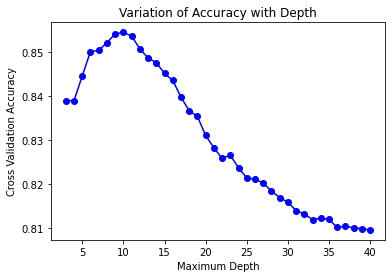

dict_items([(3, 0.8389722697143795), (4, 0.8390164808176914), (5, 0.8445889819661826), (6, 0.850161473335079), (7, 0.8504047309767933), (8, 0.8521957977570009), (9, 0.8541418955641958), (10, 0.8545399446328238), (11, 0.8536553607215775), (12, 0.850802733592346), (13, 0.8486798793882571), (14, 0.8476405871766529), (15, 0.8451859993364546), (16, 0.8436159416197307), (17, 0.8397903670501978), (18, 0.8366945238425301), (19, 0.835411937315731), (20, 0.8310777260192722), (21, 0.8282914289919512), (22, 0.8258590090483257), (23, 0.826610837404701), (24, 0.8237362648646783), (25, 0.821392181556222), (26, 0.8211489141349129), (27, 0.8202644475788047), (28, 0.8184512422408083), (29, 0.8169695627225316), (30, 0.8159081441776328), (31, 0.8139843193976553), (32, 0.8132324837065837), (33, 0.8119499925308343), (34, 0.8122816454852867), (35, 0.8119941962994502), (36, 0.8101589110812343), (37, 0.8104905591458893), (38, 0.810070410637852), (39, 0.8098934830980486), (40, 0.8096059996836301)])
The best dep

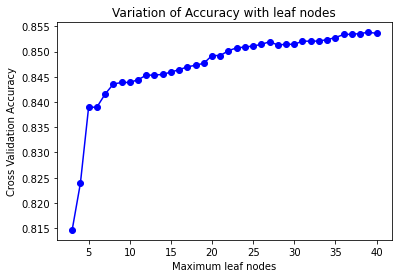

dict_items([(3, 0.814647798894368), (4, 0.8238911002997691), (5, 0.8389722697143795), (6, 0.8389722697143795), (7, 0.8415596204441451), (8, 0.8435497508770462), (9, 0.8438814258355869), (10, 0.8438814258355869), (11, 0.8444121277733402), (12, 0.84531878423011), (13, 0.8453408958940127), (14, 0.8454734803059741), (15, 0.8459378765908039), (16, 0.8464022630960388), (17, 0.8469771883615976), (18, 0.8472867858848174), (19, 0.847684812949357), (20, 0.8492106864566548), (21, 0.8492106864566548), (22, 0.8501836192275636), (23, 0.8507364254945236), (24, 0.8508912046969439), (25, 0.851112328670667), (26, 0.8514218895204063), (27, 0.8519526232418426), (28, 0.8513113849886642), (29, 0.8514440500822831), (30, 0.8514440549720804), (31, 0.8520632182348369), (32, 0.8520632182348369), (33, 0.8520853396783344), (34, 0.8523728230927528), (35, 0.852770845267495), (36, 0.853390006085353), (37, 0.8534342269682597), (38, 0.853566911621068), (39, 0.8538322515879007), (40, 0.8536111202794812)])
The best leaf 

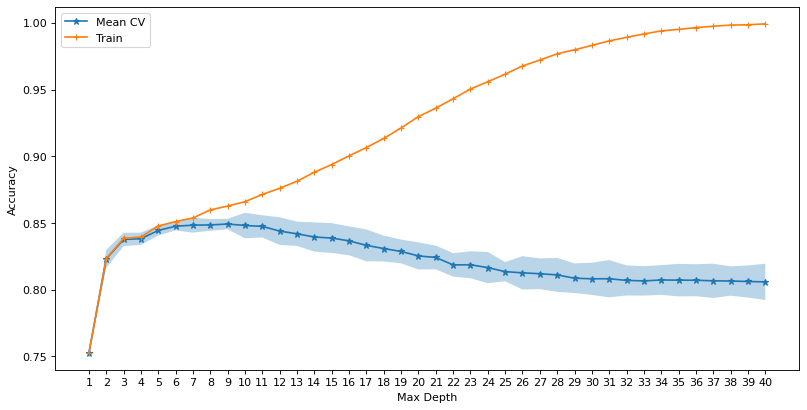

<Figure size 72x72 with 0 Axes>

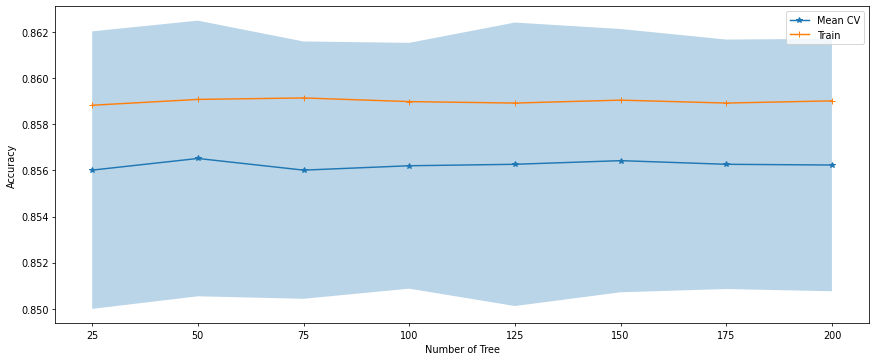

<Figure size 72x72 with 0 Axes>

In [4]:
# Python libraries 
import os
import time
import collections
import joblib
import pandas as pd
import numpy as np
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

import types
from botocore.client import Config
import ibm_boto3

class Model:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.cat_ix = X.select_dtypes(include=['object', 'bool']).columns
        self.num_ix = X.select_dtypes(include=['int64', 'float64']).columns
        self.best_depth = 0
        self.best_leaf_node = 0

# optimal_depth_of_tree        
    def find_optimal_depth_of_tree(self):
        print('--optimal depth of tree--')
        depths = list(range(3, 41))
        depth_result = {}
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        
        start_time = time.time()
        for depth in depths:
            dtree = DecisionTreeClassifier(max_depth=depth, random_state=42)
            pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
            scores = cross_val_score(estimator=pipe, X=self.X, y=self.y, cv=5, n_jobs=-1)
            depth_result[depth] = scores.mean()

        time_elapsed = (time.time() - start_time)
        print("Computational time [optimal_depth_of_tree]:{}".format(time_elapsed))
        return depth_result
    
    # Perform 5-fold cross-validation to determine what the best max_depth
    def find_optimal_depth_of_tree_on_Xtrain(self):
        print('--optimal depth of tree on Xtrain feature set--')
        depths = list(range(1, 41))
        train_scores = []
        cvmeans = []
        cvstds = []
        cv_scores = []
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        
        start_time = time.time()
        for depth in depths:
            dtree = DecisionTreeClassifier(max_depth=depth, random_state=42)
            # wrap the model a pipeline
            pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
            # Perform 5-fold cross validation and store results
            train_scores.append(pipe.fit(X_train, y_train).score(X_train, y_train))
            scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=5)
            cvmeans.append(scores.mean())
            cvstds.append(scores.std())

        cvmeans = np.array(cvmeans)
        cvstds = np.array(cvstds)
        time_elapsed = (time.time() - start_time)
        print("Computational time [optimal depth of tree on Xtrain]:{}".format(time_elapsed))
        return depths, cvmeans, cvstds, train_scores
    
    # Visualize the results with mean & sd across the validation sets
    def plot_optimal_depth_of_tree_on_Xtrain(self, depths, cvmeans, cvstds, train_scores):
        from matplotlib.pyplot import figure
        figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
        plt.plot(depths, cvmeans, '*-', label="Mean CV")
        plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
        ylim = plt.ylim()
        plt.plot(depths, train_scores, '-+', label="Train")
        plt.legend()
        plt.ylabel("Accuracy")
        plt.xlabel("Max Depth")
        plt.xticks(depths);
        plt.figure(figsize=(1,1))
    
    def plot_optimal_depth_of_tree(self, depth):
        lists = sorted(depth.items())
        x, y = zip(*lists) 
        plt.ylabel("Cross Validation Accuracy")
        plt.xlabel("Maximum Depth")
        plt.title('Variation of Accuracy with Depth')
        plt.plot(x, y, 'b-', marker='o')
        plt.show()
    
    def evaluate_optimal_depth_of_tree(self, depth):
        # To find the optimal depth 
        print(depth.items())
        self.best_depth = sorted(depth, key=depth.get, reverse=True)[0]
        print("The best depth was found to be:", self.best_depth)
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        
        start_time = time.time()
        dtree = DecisionTreeClassifier(max_depth=self.best_depth, random_state=42)
        pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
        pipe.fit(X_train, y_train)
        time_elapsed = (time.time() - start_time)
        
        #Check Accuracy of income prediction in Train and Test Set
        print("Accuracy, Training Set: {:.2%}".format(metrics.accuracy_score(y_train, pipe.predict(X_train))))
        print("Accuracy, Testing Set: {:.2%}".format(metrics.accuracy_score(y_test, pipe.predict(X_test))))
        print("Computational time [evaluate_depth_of_tree]:{}".format(time_elapsed))
        
        #Get Performance by Class (Lookup Confusion Matrix)
        threshold = 0.5 # set threshold as 0.5
        y_pred = (pipe.predict_proba(X_test)[:,1] >= threshold).astype(int)
        print(pd.crosstab(y_test, y_pred, margins=True, rownames=['Actual'], colnames=['Predicted']))
        
        # Confusion Matrix
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        print(f"confusion matrix:\n {conf_mat}")
        
# optimal_leaf_nodes    
    def find_optimal_leaf_nodes(self):
        print('--optimal leaf nodes--')
        #Find optimal leaf nodes
        leaf_nodes = list(range(3, 41))
        leaf_nodes_result = {}
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        
        start_time = time.time()
        for leaf_node in leaf_nodes:
            dtree = DecisionTreeClassifier(max_depth=self.best_depth, max_leaf_nodes=leaf_node,random_state=42)
            pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
            scores = cross_val_score(estimator=pipe, X=self.X, y=self.y, cv=5, n_jobs=-1)
            leaf_nodes_result[leaf_node] = scores.mean()
        
        time_elapsed = (time.time() - start_time)
        print("Computational time [optimal_leaf_nodes]:{}".format(time_elapsed))
        return leaf_nodes_result
    
    def plot_optimal_leaf_nodes(self, leaf_nodes):
        lists = sorted(leaf_nodes.items())
        x, y = zip(*lists) 
        plt.ylabel("Cross Validation Accuracy")
        plt.xlabel("Maximum leaf nodes")
        plt.title('Variation of Accuracy with leaf nodes')
        plt.plot(x, y, 'b-', marker='o')
        plt.show()
        
    def evaluate_optimal_leaf_nodes(self, leaf_nodes):
        # To find the optimal leaf node 
        print(leaf_nodes.items())
        self.best_leaf_node = sorted(leaf_nodes, key=leaf_nodes.get, reverse=True)[0]
        print("The best leaf node was found to be:", self.best_leaf_node)
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        
        start_time = time.time()
        dtree = DecisionTreeClassifier(max_depth=self.best_depth, max_leaf_nodes=self.best_leaf_node, random_state=42)
        pipe  = Pipeline(steps=[('transformer',ct),('cart',dtree)])
        pipe.fit(X_train, y_train)
        time_elapsed = (time.time() - start_time)
        print("---parameter")
        print(f"best_depth: {self.best_depth}")
        print(f"best_leaf_node: {self.best_leaf_node}")
        
        #Check Accuracy of income prediction in Train and Test Set
        print("Accuracy, Training Set: {:.2%}".format(metrics.accuracy_score(y_train, pipe.predict(X_train))))
        print("Accuracy, Testing Set: {:.2%}".format(metrics.accuracy_score(y_test, pipe.predict(X_test))))
        print("Computational time [evaluate_optimal_leaf_nodes]:{}".format(time_elapsed))
        
        #Get Performance by Class (Lookup Confusion Matrix)
        threshold = 0.5 # set threshold as 0.5
        y_pred = (pipe.predict_proba(X_test)[:,1] >= threshold).astype(int)
        print(pd.crosstab(y_test, y_pred, margins=True, rownames=['Actual'], colnames=['Predicted']))
        
        # Confusion Matrix
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        print(f"confusion matrix:\n {conf_mat}")

# optimal_n_estimators        
# ensemble
    def find_optimal_n_estimators(self):
        print('--optimal n_estimators--')
        
        ntrees = list(range(25, 201, 25))
        print(f"ntrees: {ntrees}")
        train_scores = []
        cvmeans = []
        cvstds = []
        cv_scores = []
        steps = [('c',OneHotEncoder(handle_unknown='ignore'),self.cat_ix), ('n',MinMaxScaler(),self.num_ix)]
        # one hot encode categorical, normalize numerical
        ct = ColumnTransformer(steps)
        #use stratify for un balanced number of examples for each class label
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3,random_state=42,shuffle=True)
        
        start_time = time.time()
        for tree in ntrees:
            clf  = DecisionTreeClassifier(max_leaf_nodes=self.best_leaf_node,
                                       criterion="gini", 
                                       max_depth=self.best_depth,
                                       random_state=42)
            
            bag = BaggingClassifier(base_estimator=clf,
                                    n_estimators=tree,
                                    oob_score=True,
                                    bootstrap=True,
                                    bootstrap_features=False,
                                    n_jobs=-1,
                                    random_state=42)
            
            pipe  = Pipeline(steps=[('transformer',ct),('bag',bag)])
            # Perform 5-fold cross validation and store results
            train_scores.append(pipe.fit(X_train, y_train).score(X_train, y_train))
            scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=5)
            cvmeans.append(scores.mean())
            cvstds.append(scores.std())

        cvmeans = np.array(cvmeans)
        cvstds = np.array(cvstds)
        
        time_elapsed = (time.time() - start_time)
        print("Computational time [optimal_leaf_nodes]:{}".format(time_elapsed))
        
        print("n_tree --> Training score --> cvmeans")
        for tree, train_score, cvmean in zip(list(ntrees), list(train_scores), list(cvmeans)):
            print(f"({tree} --> {train_score} --> {cvmean})")
    
        return ntrees, cvmeans, cvstds, train_scores
    
    def plot_optimal_n_estimators(self, ntrees, cvmeans, cvstds, train_scores):
        from matplotlib.pyplot import figure
        figure(num=None, figsize=(15, 6), dpi=70, facecolor='w', edgecolor='k')
        # plot means and shade the 2 SD interval
        plt.plot(ntrees, cvmeans, '*-', label="Mean CV")
        plt.fill_between(ntrees, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
        ylim = plt.ylim()
        plt.plot(ntrees, train_scores, '-+', label="Train")
        plt.legend()
        plt.ylabel("Accuracy")
        plt.xlabel("Number of Tree")
        plt.xticks(ntrees);
        plt.figure(figsize=(1,1))
        
if __name__ =='__main__':

    client = ibm_boto3.client(service_name='s3',
                              ibm_api_key_id='qOYLX9hHTq5wVFsyqqoueS5Rpvfz2_j08TnpS4qBJKrf',
                              ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
                              config=Config(signature_version='oauth'),
                              endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

    body = client.get_object(Bucket='mlproject-donotdelete-pr-g6j7hl10bonvf1',Key='adult.csv')['Body']
    df = pd.read_csv(body)
    print(f"df.shape:{df.shape}")
    
    #Prepocessing
    features = 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country'
    target = 'IncomeGroup'
    X = df[features.split()]
    y = df[target]
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    
    model = Model(X,y)
    
    #Find optimal depth of trees
    depth = model.find_optimal_depth_of_tree()
    model.plot_optimal_depth_of_tree(depth)
    model.evaluate_optimal_depth_of_tree(depth)
    
    #Find optimal leaf nodes
    leaf_nodes = model.find_optimal_leaf_nodes()
    model.plot_optimal_leaf_nodes(leaf_nodes)
    model.evaluate_optimal_leaf_nodes(leaf_nodes)
    
    #Find optimal depth of trees on Xtrain feature set
    depths, cvmeans, cvstds, train_scores = model.find_optimal_depth_of_tree_on_Xtrain()
    model.plot_optimal_depth_of_tree_on_Xtrain(depths, cvmeans, cvstds, train_scores)
    
    #Find optimal number of trees on Xtrain feature set
    ntrees, cvmeans, cvstds, train_scores = model.find_optimal_n_estimators()
    model.plot_optimal_n_estimators(ntrees, cvmeans, cvstds, train_scores)

<a id="compaire"></a>
### 4 Model Comparison

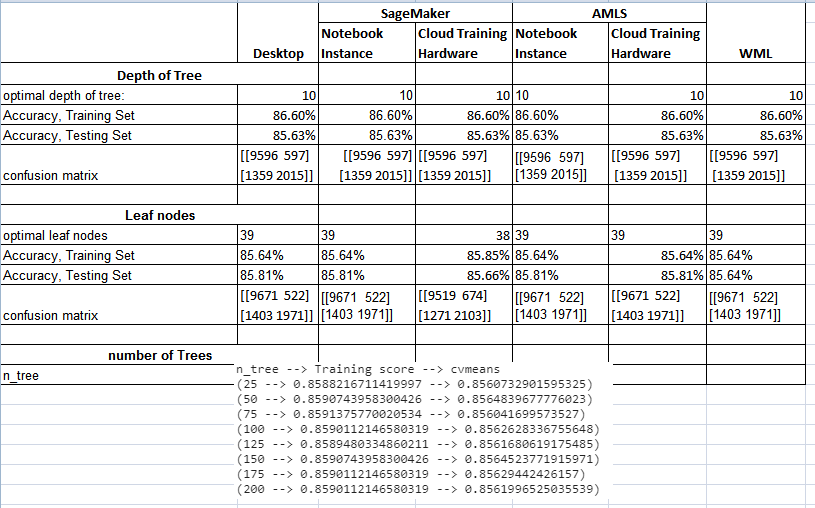

In [6]:
from IPython.display import Image

Image(filename='images/Exp3/compare.png')

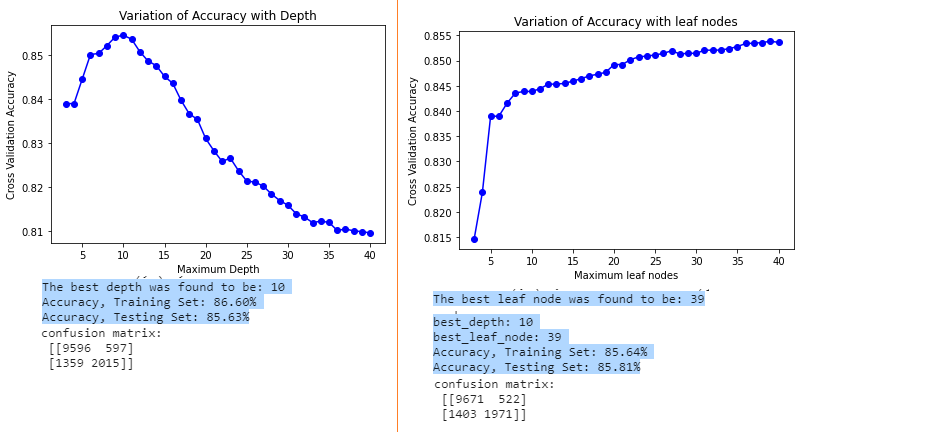

In [2]:
Image(filename='images/Exp3/result.png')

# Here we perform 5-fold cross-validation to determine what the best max_depth would be for a single decision tree
  # - Visualize the results with mean +/- 2 sd's across the validation sets
  # - Based on the plot below, the best depth was found at 10.



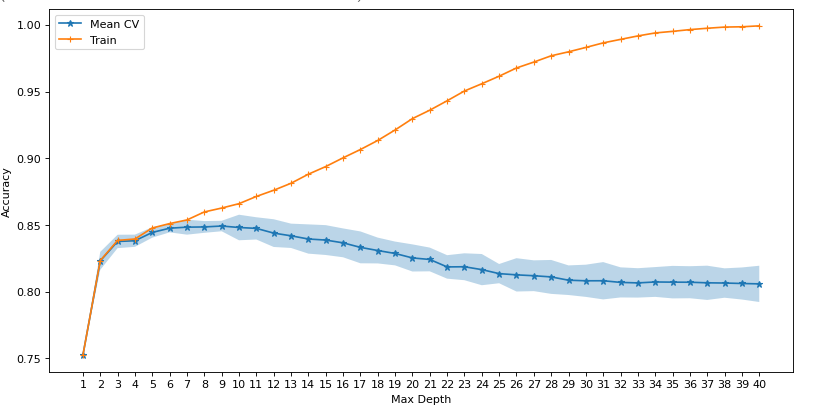

In [4]:
Image(filename='images/Exp3/result2.png')

# Here we perform 5-fold cross-validation to determine what the best max_depth would be for a single decision tree
  # - Visualize the results with mean +/- 2 sd's across the validation sets
  # - the deeper the tree, the more prone to overfitting.
  # - Based on the plot below, the test set's accuracy maximum around 85-86% around a max_depth of 9-11. Any of those values would be reasonable to choose for a best predictive model. 

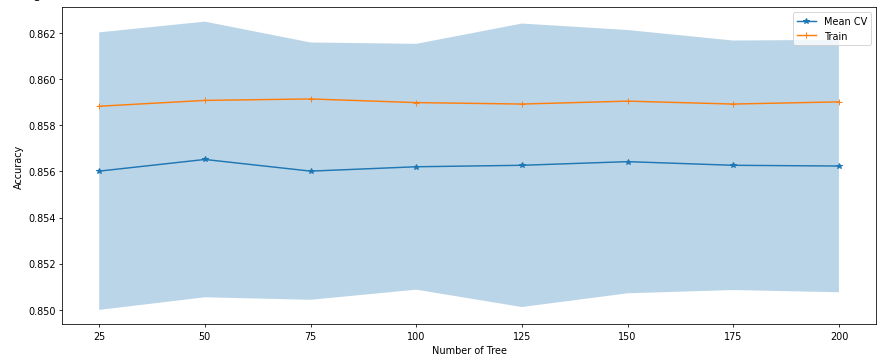

In [5]:
Image(filename='images/Exp3/result3.png')

# - fit many bagged trees on the entire Xtrain feature set.
